# import Library and data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.utils import plot_model

import random
import os

import pydot
import graphviz

In [ ]:
pathColab = "/content/gdrive/MyDrive/Colab Notebooks/FlacAIModels/deepLearning/dataset/SurfaceLimited_SevilleUni_All/"

In [ ]:
trainSimple = pd.read_pickle(pathColab + "trainSimple.pkl")
testSimple = pd.read_pickle(pathColab + "testSimple.pkl")

In [ ]:
trainSimple.index.value_counts()

(1275, 1)     244
(1275, 2)     244
(1785, 3)     244
(1785, 4)     244
(1300, 4)     244
             ... 
(1770, 60)    240
(1770, 59)    240
(1770, 58)    240
(1770, 57)    240
(2295, 80)    240
Length: 3280, dtype: int64

In [ ]:
trainSimple["zDisp(m)"]

location_id  step
1275         1      -0.000223
             1      -0.000349
             1      -0.000051
             1      -0.000134
             1      -0.000038
                       ...   
2295         80     -0.076678
             80     -0.064267
             80     -0.041968
             80     -0.064287
             80     -0.041065
Name: zDisp(m), Length: 790726, dtype: float32

In [ ]:
trainSimple[trainSimple["locationID"] == 1275].index.value_counts

<bound method IndexOpsMixin.value_counts of MultiIndex([(1275,  1),
            (1275,  1),
            (1275,  1),
            (1275,  1),
            (1275,  1),
            (1275,  1),
            (1275,  1),
            (1275,  1),
            (1275,  1),
            (1275,  1),
            ...
            (1275, 80),
            (1275, 80),
            (1275, 80),
            (1275, 80),
            (1275, 80),
            (1275, 80),
            (1275, 80),
            (1275, 80),
            (1275, 80),
            (1275, 80)],
           names=['location_id', 'step'], length=19286)>

# make dataScaled

In [ ]:
trainSimple["locationID"].value_counts()

1275    19286
1790    19286
1800    19286
2010    19286
2015    19286
2020    19286
2025    19286
2030    19286
2035    19286
2040    19286
2045    19286
2255    19286
2260    19286
2265    19286
2270    19286
2275    19286
2280    19286
2285    19286
2290    19286
1795    19286
1785    19286
1280    19286
1780    19286
1285    19286
1290    19286
1295    19286
1300    19286
1305    19286
1310    19286
1520    19286
1525    19286
1530    19286
1535    19286
1540    19286
1545    19286
1550    19286
1555    19286
1765    19286
1770    19286
1775    19286
2295    19286
Name: locationID, dtype: int64

In [ ]:
trainSimple.columns

Index(['faceP', 'groutP', 'treat', 'waterT', 'burdenL', 'geoProp_0',
       'geoProp_2', 'geoProp_3', 'geoProp_4', 'geoProp_5', 'geoProp_6',
       'geoProp_7', 'locationID', 'soilExcavation', 'shifted_zDisp(m)_1',
       'zDisp(m)'],
      dtype='object')

In [ ]:
train_features = trainSimple.iloc[:, :-2].values
train_target = trainSimple.iloc[:, [-2,-1]].values

# Scale the features only
scaler = MinMaxScaler()
train_features_scaled = scaler.fit_transform(train_features)

# Combine the scaled features and the target
trainSimple_scaled = np.hstack((train_features_scaled, train_target))

In [ ]:
test_features = testSimple.iloc[:, :-2].values
test_target = testSimple.iloc[:,[-2,-1]].values
# Scale the features only
scaler = MinMaxScaler()
test_features_scaled = scaler.fit_transform(test_features)

# Combine the scaled features and the target
testSimple_scaled = np.hstack((test_features_scaled, test_target))

In [ ]:
trainSimple_scaled.shape == trainSimple.shape

True

## Prepare for NN

In [ ]:
# Define the number of features in the input data
sequence_length = 80
num_features = trainSimple.shape[1] - 1
num_features

15

In [ ]:
# Define a generator function to load the data in batches
def data_generator(data, sequence_length, batch_size):
    num_sequences = len(data) - sequence_length
    while True:
        batch_X = np.zeros((batch_size, sequence_length, num_features))
        batch_y = np.zeros((batch_size, 1))
        for i in range(batch_size):
            idx = random.randint(0, num_sequences-1)
            batch_X[i] = data[idx:idx+sequence_length, :-1]
            batch_y[i] = data[idx+sequence_length, -1]
        yield batch_X, batch_y

# Define the batch size
batch_size = 128

# Define the number of training and validation steps per epoch
train_steps_per_epoch = (len(trainSimple) - sequence_length) // batch_size
val_steps_per_epoch = (len(testSimple) - sequence_length) // batch_size

# RNN

In [ ]:
import numpy as np
from keras.layers import Input, LSTM, Dense, GRU, SimpleRNN
from keras.models import Model
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt

## Four layers

In [ ]:
# Define the input shape
input_shape = (sequence_length, num_features)

# Define the number of RNN units in the layers
rnn_units_1 = 128
rnn_units_2 = 64
rnn_units_3 = 32
rnn_units_4 = 16

# Define the input layer
inputs = Input(shape=input_shape)

x1 = SimpleRNN(rnn_units_1, kernel_regularizer=l2(0.001), return_sequences=True, activation="tanh")(inputs)
x2 = SimpleRNN(rnn_units_2, return_sequences=True, activation="tanh")(x1)
x3 = SimpleRNN(rnn_units_3, return_sequences=True, activation="tanh")(x2)
x4 = SimpleRNN(rnn_units_4, activation="tanh")(x3)

# Add a dense output layer with L2 regularization
outputs = Dense(1, activation="linear")(x4)

# Define the model
model0 = Model(inputs=inputs, outputs=outputs)

# Compile the model
model0.compile(loss='mse', optimizer='sgd')
model0.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 15)]          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 80, 128)           18432     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 80, 64)            12352     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 80, 32)            3104      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 16)                784       
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 34,689
Trainable params: 34,689
Non-trainable p

In [ ]:
x,y = next(data_generator(trainSimple_scaled, sequence_length, batch_size))

In [ ]:
y.shape

(128, 1)

In [ ]:
from tensorflow.python.distribute.input_lib import time
# Train the model
start_time = time.time()
historyRNN1 = model0.fit(data_generator(trainSimple_scaled, sequence_length, batch_size),
          steps_per_epoch=train_steps_per_epoch,
          epochs=60,
          validation_data=data_generator(testSimple_scaled, sequence_length, batch_size),
          validation_steps=val_steps_per_epoch,
          callbacks=[EarlyStopping(patience=6, restore_best_weights=True)])
end_time = time.time()

Epoch 1/60
6176/6176 [==============================] - 2095s 337ms/step - loss: 0.0256 - val_loss: 0.0243
Epoch 2/60
3655/6176 [================>.............] - ETA: 13:48 - loss: 0.0202

KeyboardInterrupt: ignored

In [ ]:
plt.plot(historyRNN1.history['loss'], label='Training loss')
plt.plot(historyRNN1.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: ignored

In [ ]:
import keras
pathSave = "/content/gdrive/MyDrive/Colab Notebooks/FlacAIModels/deepLearning/surfaceDispSevilleUni/"
# Save the model to a file
model0= keras.models.load_model(pathSave+ 'modelRNN_allSoil.h5')

#### Test model

In [ ]:
x_test, y_test= next(data_generator(trainSimple_scaled, sequence_length, batch_size=3565))

In [ ]:
y_pred= model0.predict(x_test)

112/112 [==============================] - 3s 30ms/step


In [ ]:
plt.figure(figsize=(15,7), dpi=150)
# Plot the predicted values
plt.plot(y_pred, label='Predicted')

# Plot the real values
plt.plot(y_test, label='Real')

# Add legend
plt.legend()

# Set x-axis limits
plt.xlim(0, 3565)

# Add labels and title
plt.xlabel('Different point and time')
plt.ylabel('Displacement value')
plt.title('Predicted vs. Real Values')
# Show the plot
plt.show()

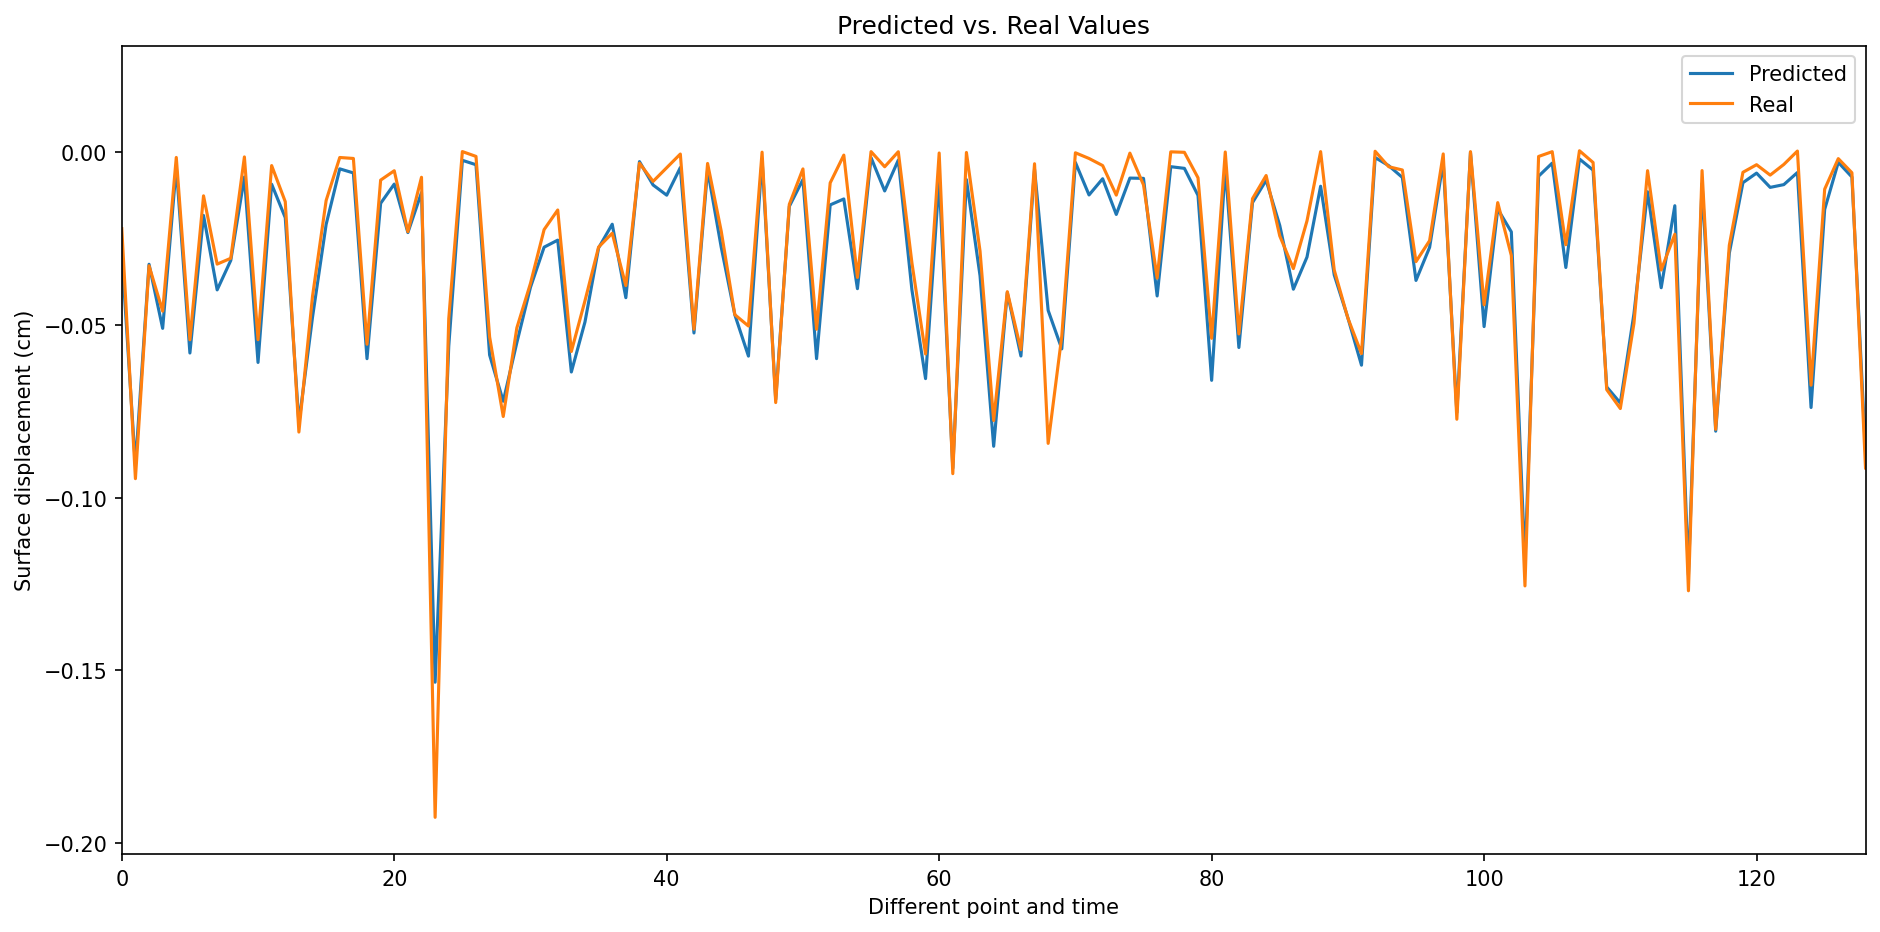

In [ ]:
plt.figure(figsize=(15,7), dpi=150)
# Plot the predicted values
plt.plot(y_pred, label='Predicted')

# Plot the real values
plt.plot(y_test, label='Real')

# Add legend
plt.legend()

# Set x-axis limits
plt.xlim(0, batch_size)

# Add labels and title
plt.xlabel('Different point and time')
plt.ylabel('Surface displacement (cm)')
plt.title('Predicted vs. Real Values')
plt.savefig("real_Pred_RNN2.png")
# Show the plot
plt.show()

In [ ]:
plt.figure(figsize=(25,7), dpi=150)

# Plot the predicted values with a dashed red line
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')

# Plot the real values with a solid blue line
plt.plot(y_test, label='Real', color='blue', linestyle='-')

# Add legend
plt.legend()

# Add labels and title
plt.xlabel('Different point and time')
plt.ylabel('Displacement value')
plt.title('Predicted vs. Real Values')

# Show the plot
plt.show()


### Continuse

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Assuming you have y_pred and y_real as numpy arrays

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate R2 score
r2 = r2_score(y_test, y_pred)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)

# Print the results
print("RMSE: ", rmse)
print("R2 Score: ", r2)
print("MSE: ", mse)


RMSE:  0.006371875767116446
R2 Score:  0.947703704478253
MSE:  4.06008007915658e-05


# GRU

In [ ]:
import numpy as np
from keras.layers import Input, LSTM, Dense, GRU
from keras.models import Model
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt

## Four layers

In [ ]:
# Define the input shape
input_shape = (sequence_length, num_features)

# Define the number of GRU units in the layers
gru_units_1 = 128
gru_units_2 = 64
gru_units_3 = 32
gru_units_4 = 16

# Define the input layer
inputs = Input(shape=input_shape)

x1 = GRU(gru_units_1, kernel_regularizer=l2(0.001), return_sequences=True, activation="tanh", recurrent_activation="sigmoid")(inputs)
x2 = GRU(gru_units_2, return_sequences=True, activation="tanh", recurrent_activation="sigmoid")(x1)
x3 = GRU(gru_units_3, return_sequences=True, activation="tanh", recurrent_activation="sigmoid")(x2)
x4 = GRU(gru_units_4, activation="tanh", recurrent_activation="sigmoid")(x3)

# Add a dense output layer with L2 regularization
outputs = Dense(1, activation="linear")(x4)

# Define the model
model1 = Model(inputs=inputs, outputs=outputs)

# Compile the model
model1.compile(loss='mse', optimizer='sgd')
model1.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 80, 15)]          0         
                                                                 
 gru (GRU)                   (None, 80, 128)           55680     
                                                                 
 gru_1 (GRU)                 (None, 80, 64)            37248     
                                                                 
 gru_2 (GRU)                 (None, 80, 32)            9408      
                                                                 
 gru_3 (GRU)                 (None, 16)                2400      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 104,753
Trainable params: 104,753
Non-trainab

In [ ]:
from tensorflow.python.distribute.input_lib import time
# Train the model
start_time = time.time()
historyGRU1 = model1.fit(data_generator(trainSimple_scaled, sequence_length, batch_size),
          steps_per_epoch=train_steps_per_epoch,
          epochs=60,
          validation_data=data_generator(testSimple_scaled, sequence_length, batch_size),
          validation_steps=val_steps_per_epoch,
          callbacks=[EarlyStopping(patience=6, restore_best_weights=True)])
end_time = time.time()

Epoch 1/60
6176/6176 [==============================] - 121s 18ms/step - loss: 0.0260 - val_loss: 0.0251
Epoch 2/60
6176/6176 [==============================] - 114s 18ms/step - loss: 0.0203 - val_loss: 0.0197
Epoch 3/60
6176/6176 [==============================] - 113s 18ms/step - loss: 0.0159 - val_loss: 0.0155
Epoch 4/60
6176/6176 [==============================] - 112s 18ms/step - loss: 0.0124 - val_loss: 0.0121
Epoch 5/60
6176/6176 [==============================] - 114s 18ms/step - loss: 0.0098 - val_loss: 0.0096
Epoch 6/60
6176/6176 [==============================] - 112s 18ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 7/60
6176/6176 [==============================] - 113s 18ms/step - loss: 0.0060 - val_loss: 0.0062
Epoch 8/60
6176/6176 [==============================] - 114s 18ms/step - loss: 0.0048 - val_loss: 0.0051
Epoch 9/60
6176/6176 [==============================] - 113s 18ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 10/60
6176/6176 [==============================] 

In [ ]:
plt.plot(historyGRU1.history['loss'], label='Training loss')
plt.plot(historyGRU1.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import keras
pathSave = "/content/gdrive/MyDrive/Colab Notebooks/FlacAIModels/deepLearning/surfaceDispSevilleUni/"
# Save the model to a file
model1= keras.models.load_model(pathSave+ 'modelGRU_allSoil.h5')

#### Test model

In [ ]:
x_test, y_test= next(data_generator(trainSimple_scaled, sequence_length, batch_size=3565))

In [ ]:
y_pred= model1.predict(x_test)

112/112 [==============================] - 2s 7ms/step


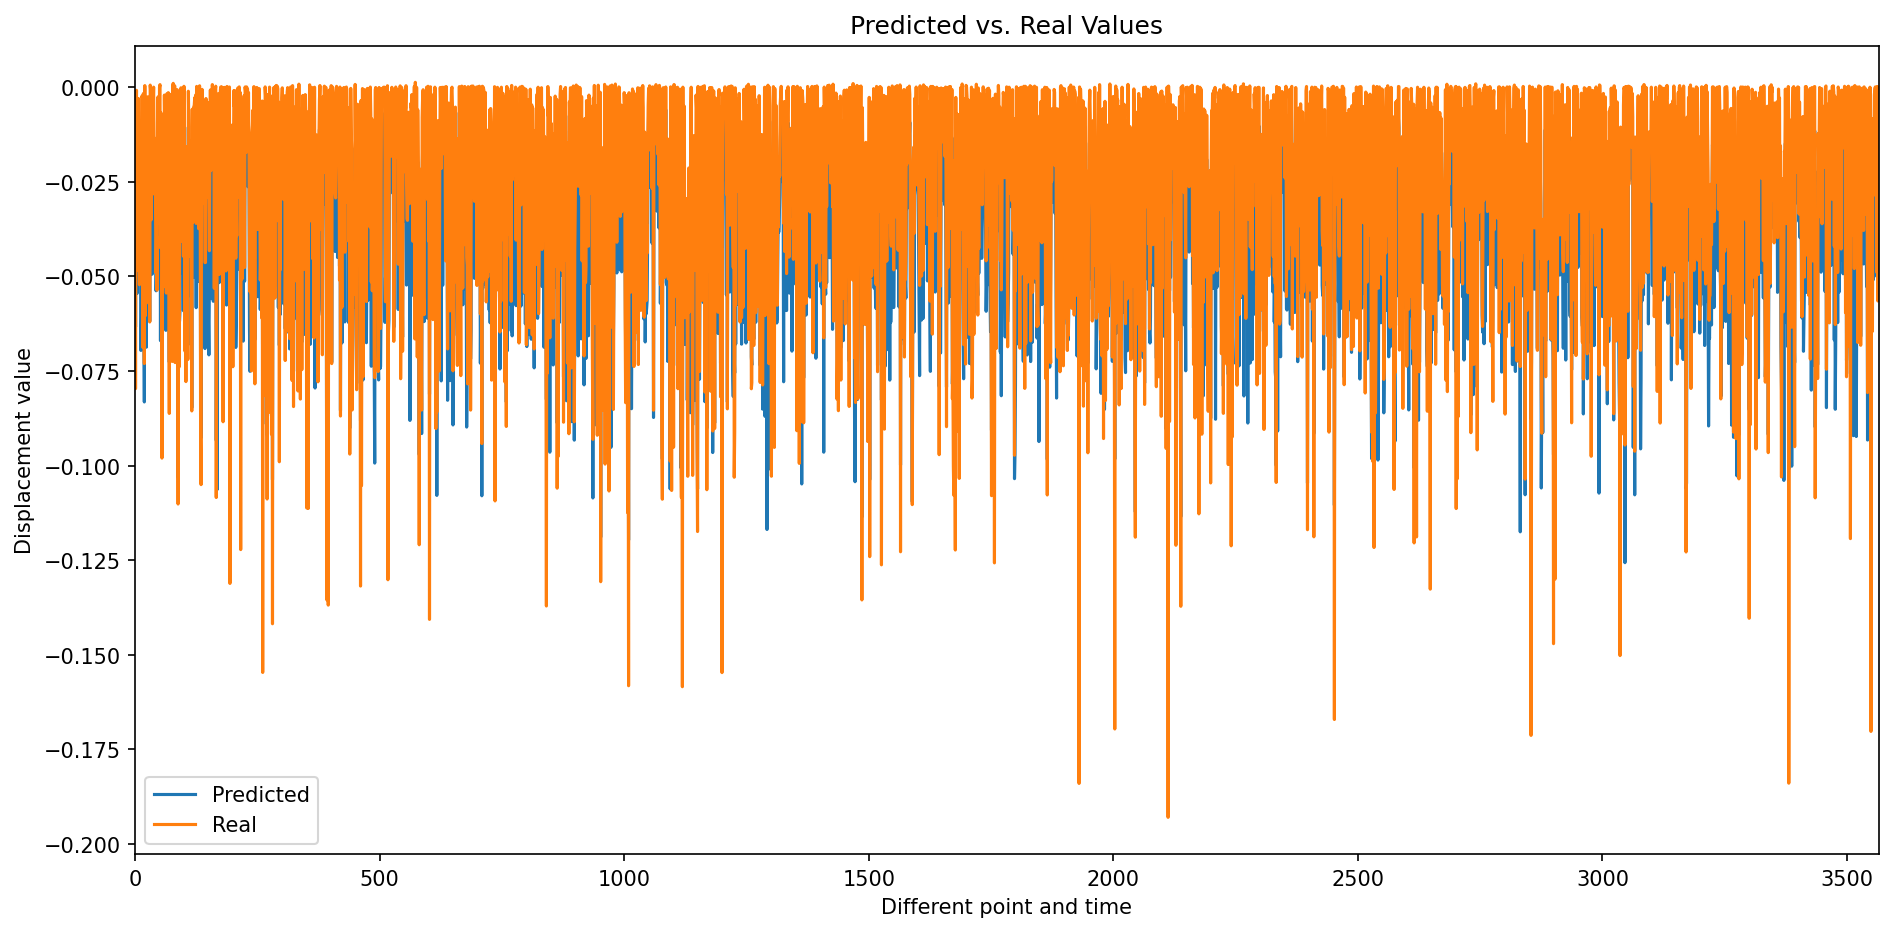

In [ ]:
plt.figure(figsize=(15,7), dpi=150)
# Plot the predicted values
plt.plot(y_pred, label='Predicted')

# Plot the real values
plt.plot(y_test, label='Real')

# Add legend
plt.legend()

# Set x-axis limits
plt.xlim(0, 3565)

# Add labels and title
plt.xlabel('Different point and time')
plt.ylabel('Displacement value')
plt.title('Predicted vs. Real Values')
# Show the plot
plt.show()

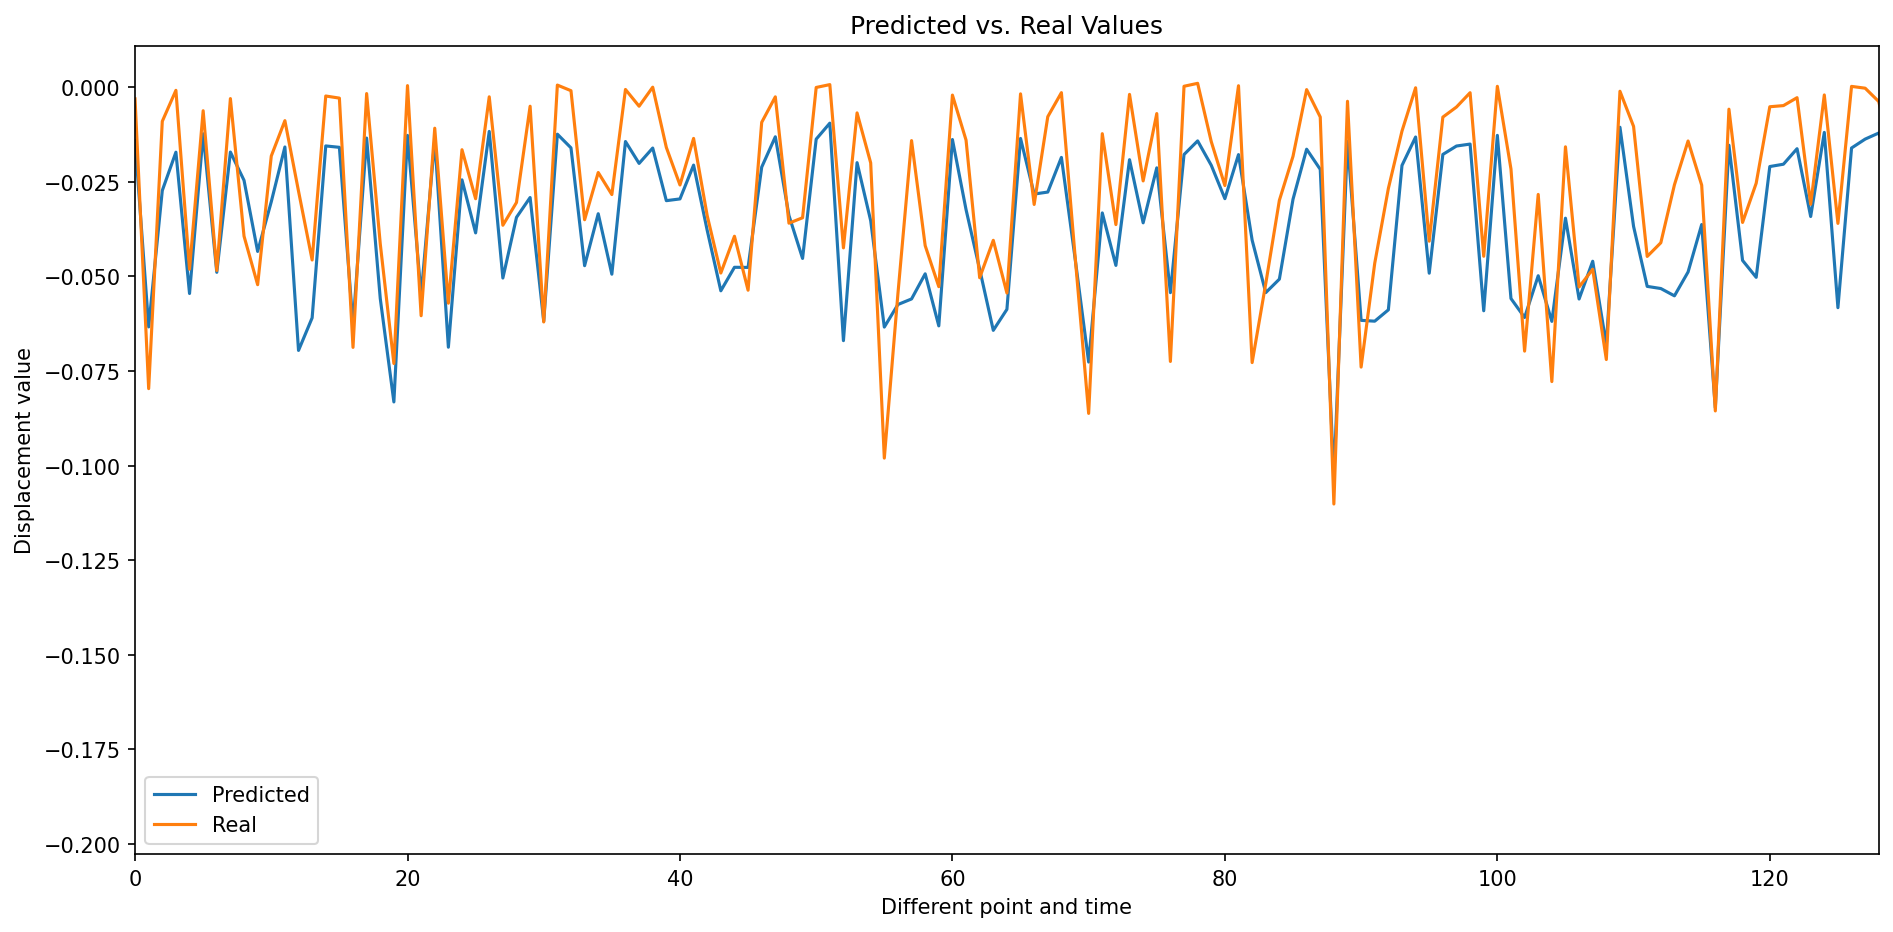

In [ ]:
plt.figure(figsize=(15,7), dpi=150)
# Plot the predicted values
plt.plot(y_pred, label='Predicted')

# Plot the real values
plt.plot(y_test, label='Real')

# Add legend
plt.legend()

# Set x-axis limits
plt.xlim(0, batch_size)

# Add labels and title
plt.xlabel('Different point and time')
plt.ylabel('Displacement value')
plt.title('Predicted vs. Real Values')
# Show the plot
plt.show()

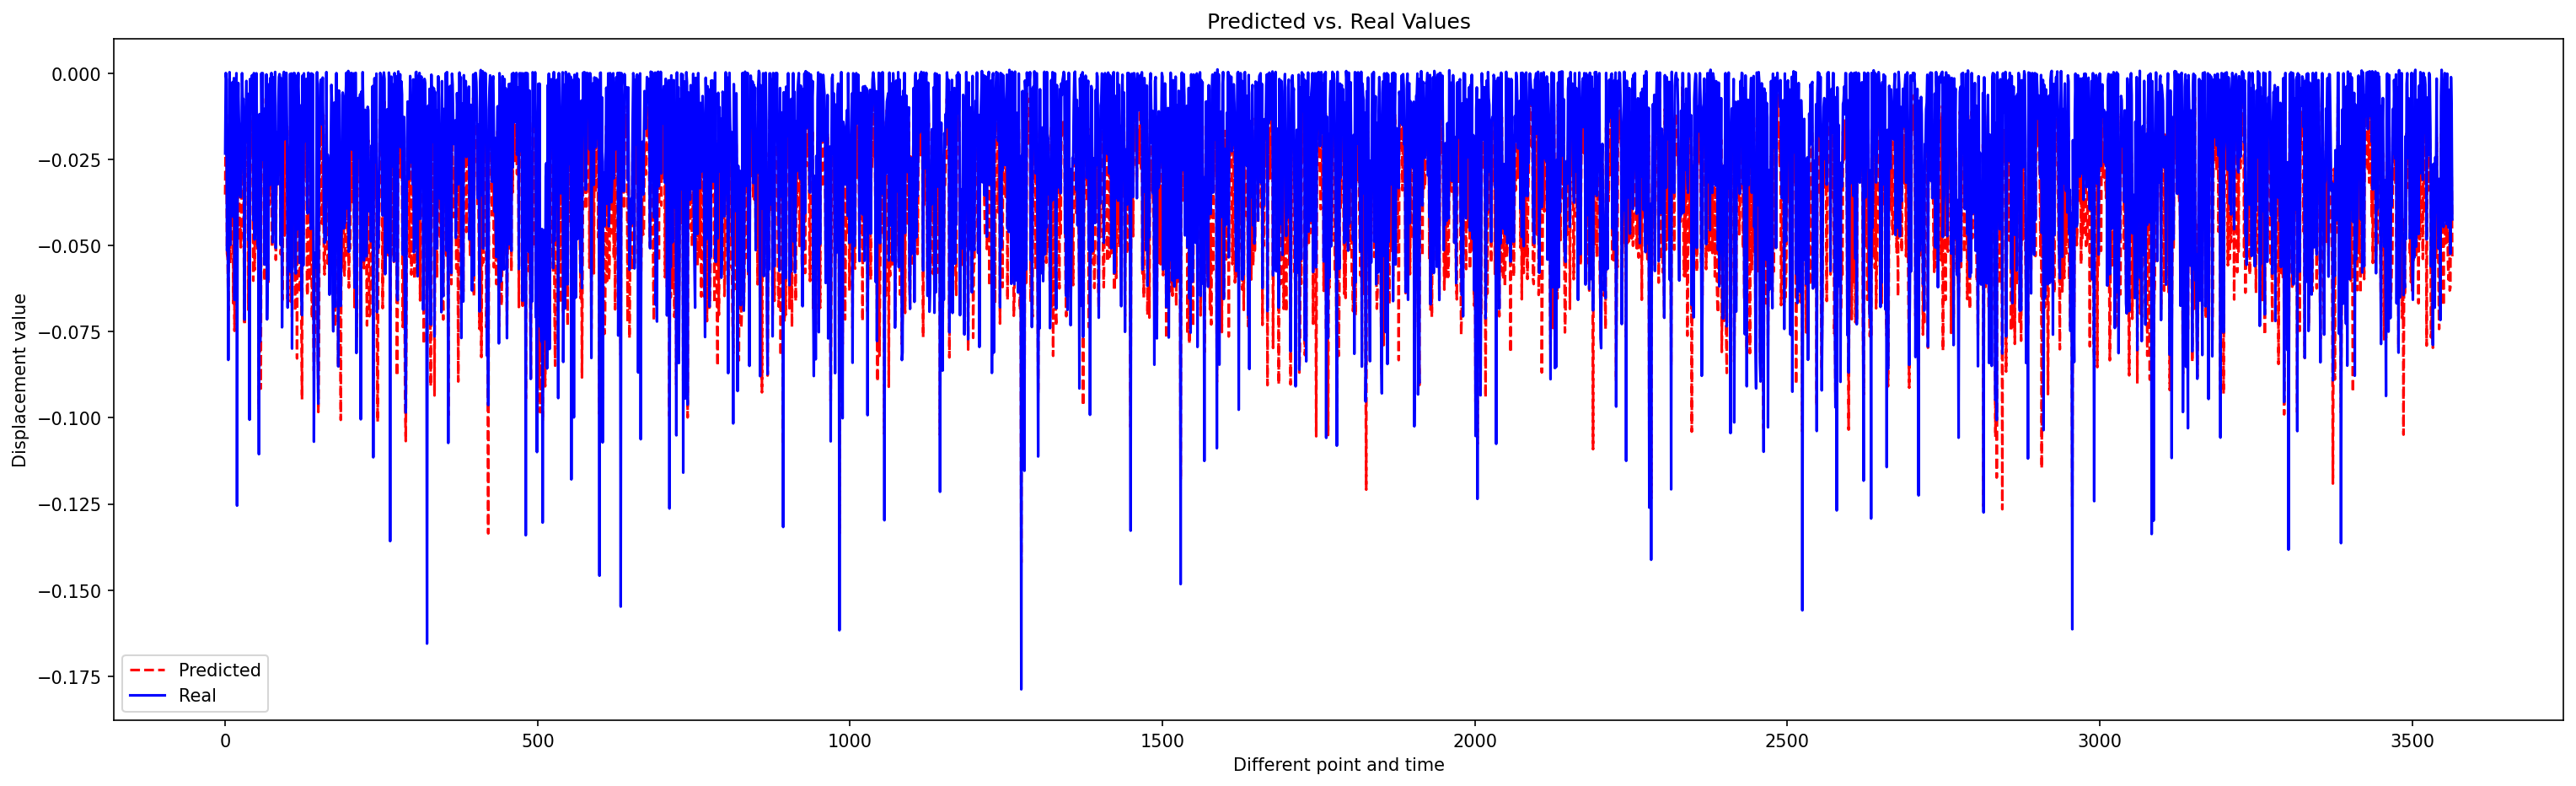

In [ ]:
plt.figure(figsize=(25,7), dpi=150)

# Plot the predicted values with a dashed red line
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')

# Plot the real values with a solid blue line
plt.plot(y_test, label='Real', color='blue', linestyle='-')

# Add legend
plt.legend()

# Add labels and title
plt.xlabel('Different point and time')
plt.ylabel('Displacement value')
plt.title('Predicted vs. Real Values')

# Show the plot
plt.show()


### Continuse

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Assuming you have y_pred and y_real as numpy arrays

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate R2 score
r2 = r2_score(y_test, y_pred)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)

# Print the results
print("RMSE: ", rmse)
print("R2 Score: ", r2)
print("MSE: ", mse)


RMSE:  0.017029698435171804
R2 Score:  0.6475579043821541
MSE:  0.000290010628792893


# LSTM

In [ ]:
import numpy as np
from keras.layers import Input, LSTM, Dense
from keras.models import Model
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt

## Four layer (128,64,32,16)

In [ ]:
sequence_length, num_features

(80, 15)

In [ ]:
# Define the input shape
input_shape = (sequence_length, num_features)

# Define the number of LSTM units in the layers
lstm_units_1 = 128
lstm_units_2 = 64
lstm_units_3 = 32
lstm_units_4 = 16

# Define the input layer
inputs = Input(shape=input_shape)

x1 = LSTM(lstm_units_1, kernel_regularizer=l2(0.001), return_sequences=True, activation="tanh", recurrent_activation="sigmoid")(inputs)
x2 = LSTM(lstm_units_2, return_sequences=True, activation="tanh", recurrent_activation="sigmoid")(x1)
x3 = LSTM(lstm_units_3, return_sequences=True, activation="tanh", recurrent_activation="sigmoid")(x2)
x4 = LSTM(lstm_units_4, activation="tanh", recurrent_activation="sigmoid")(x3)

# Add a dense output layer with L2 regularization
outputs = Dense(1, activation="linear")(x4)

# Define the model
model4 = Model(inputs=inputs, outputs=outputs)

# Compile the model
model4.compile(loss='mse', optimizer='sgd')
model4.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 15)]          0         
                                                                 
 lstm (LSTM)                 (None, 80, 128)           73728     
                                                                 
 lstm_1 (LSTM)               (None, 80, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 80, 32)            12416     
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 138,705
Trainable params: 138,705
Non-trainable

In [ ]:
from tensorflow.python.distribute.input_lib import time
# Train the model
start_time = time.time()
historyNew4 = model4.fit(data_generator(trainSimple_scaled, sequence_length, batch_size),
          steps_per_epoch=train_steps_per_epoch,
          epochs=60,
          validation_data=data_generator(testSimple_scaled, sequence_length, batch_size),
          validation_steps=val_steps_per_epoch,
          callbacks=[EarlyStopping(patience=6, restore_best_weights=True)])
end_time = time.time()

Epoch 1/60
6176/6176 [==============================] - 131s 20ms/step - loss: 0.0264 - val_loss: 0.0256
Epoch 2/60
6176/6176 [==============================] - 127s 21ms/step - loss: 0.0207 - val_loss: 0.0203
Epoch 3/60
6176/6176 [==============================] - 122s 20ms/step - loss: 0.0162 - val_loss: 0.0158
Epoch 4/60
6176/6176 [==============================] - 123s 20ms/step - loss: 0.0126 - val_loss: 0.0121
Epoch 5/60
6176/6176 [==============================] - 121s 20ms/step - loss: 0.0099 - val_loss: 0.0095
Epoch 6/60
6176/6176 [==============================] - 120s 19ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 7/60
6176/6176 [==============================] - 123s 20ms/step - loss: 0.0061 - val_loss: 0.0062
Epoch 8/60
6176/6176 [==============================] - 121s 20ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 9/60
6176/6176 [==============================] - 122s 20ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 10/60
6176/6176 [==============================] 

In [ ]:
count_time= end_time - start_time
print(f"sloving, Time taken: {count_time:.2f} seconds")

sloving, Time taken: 4718.17 seconds


In [ ]:
pathSave = '/content/gdrive/MyDrive/Colab Notebooks/FlacAIModels/deepLearning/surfaceDispSevilleUni/'

In [ ]:
# Save the model to a file
model4.save(pathSave+ 'model4LSTM_allSoil.h5')

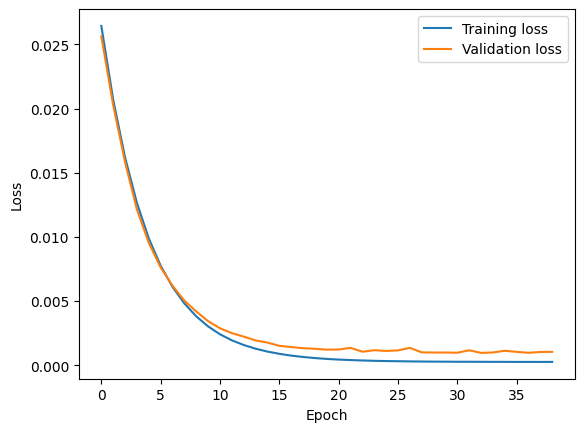

In [ ]:
plt.plot(historyNew4.history['loss'], label='Training loss')
plt.plot(historyNew4.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Test model

In [ ]:
import keras
pathSave = "/content/gdrive/MyDrive/Colab Notebooks/FlacAIModels/deepLearning/surfaceDispSevilleUni/"
# Save the model to a file
model4= keras.models.load_model(pathSave+ 'model4LSTM_allSoil.h5')

In [ ]:
len(testSimple_scaled)

196800

#### Use data Generator

In [ ]:
x_test, y_test= next(data_generator(trainSimple_scaled, sequence_length, batch_size=3565))

In [ ]:
y_test

In [ ]:
y_pred= model4.predict(x_test)

112/112 [==============================] - 3s 7ms/step


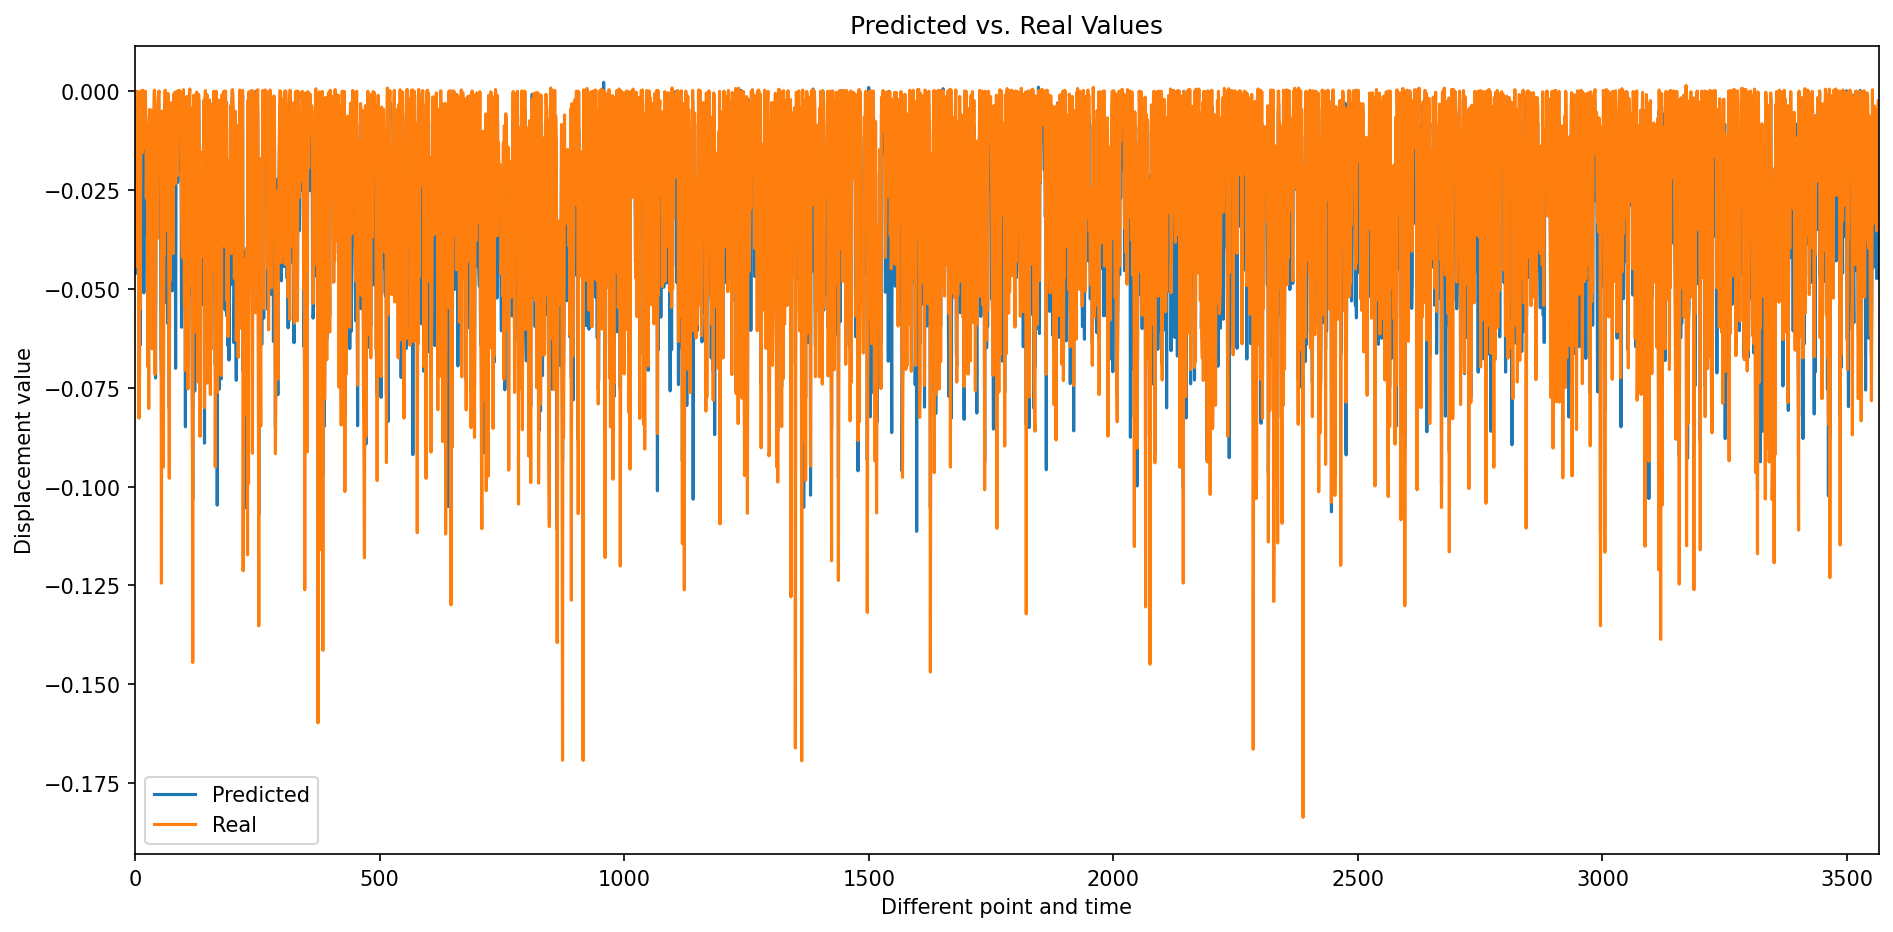

In [ ]:
plt.figure(figsize=(15,7), dpi=150)
# Plot the predicted values
plt.plot(y_pred, label='Predicted')

# Plot the real values
plt.plot(y_test, label='Real')

# Add legend
plt.legend()

# Set x-axis limits
plt.xlim(0, 3565)

# Add labels and title
plt.xlabel('Different point and time')
plt.ylabel('Displacement value')
plt.title('Predicted vs. Real Values')
# Show the plot
plt.show()

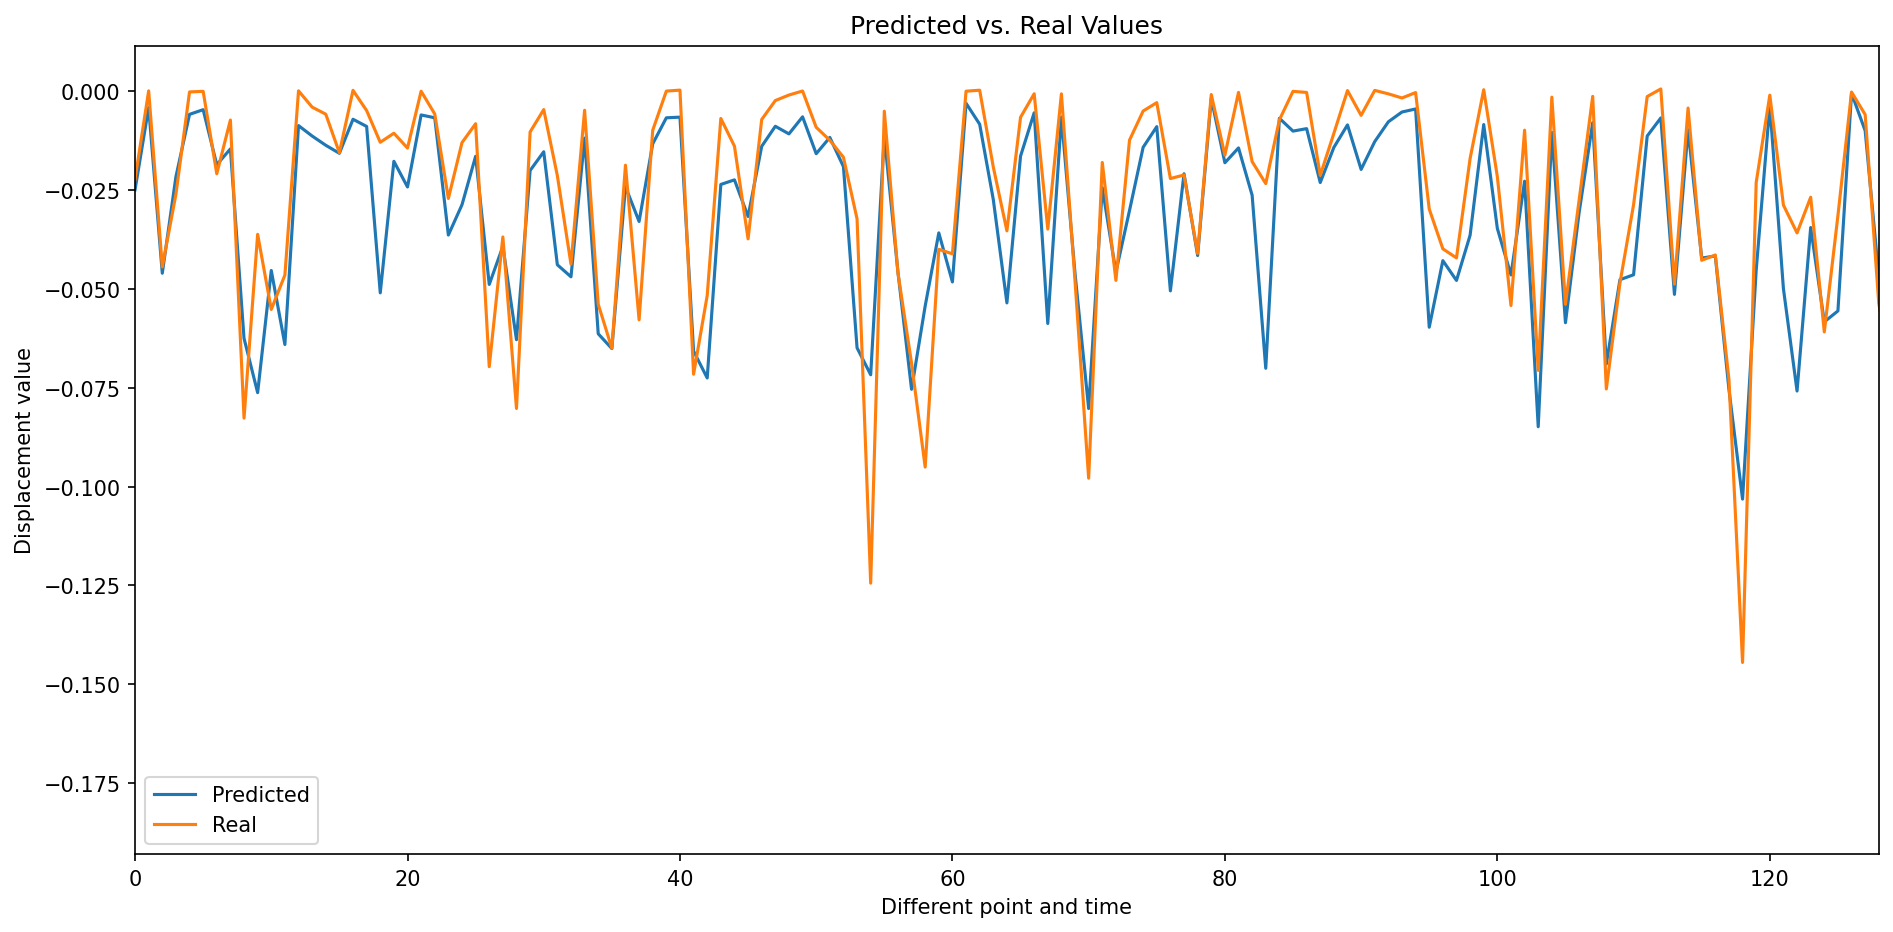

In [ ]:
plt.figure(figsize=(15,7), dpi=150)
# Plot the predicted values
plt.plot(y_pred, label='Predicted')

# Plot the real values
plt.plot(y_test, label='Real')

# Add legend
plt.legend()

# Set x-axis limits
plt.xlim(0, batch_size)

# Add labels and title
plt.xlabel('Different point and time')
plt.ylabel('Displacement value')
plt.title('Predicted vs. Real Values')
# Show the plot
plt.show()

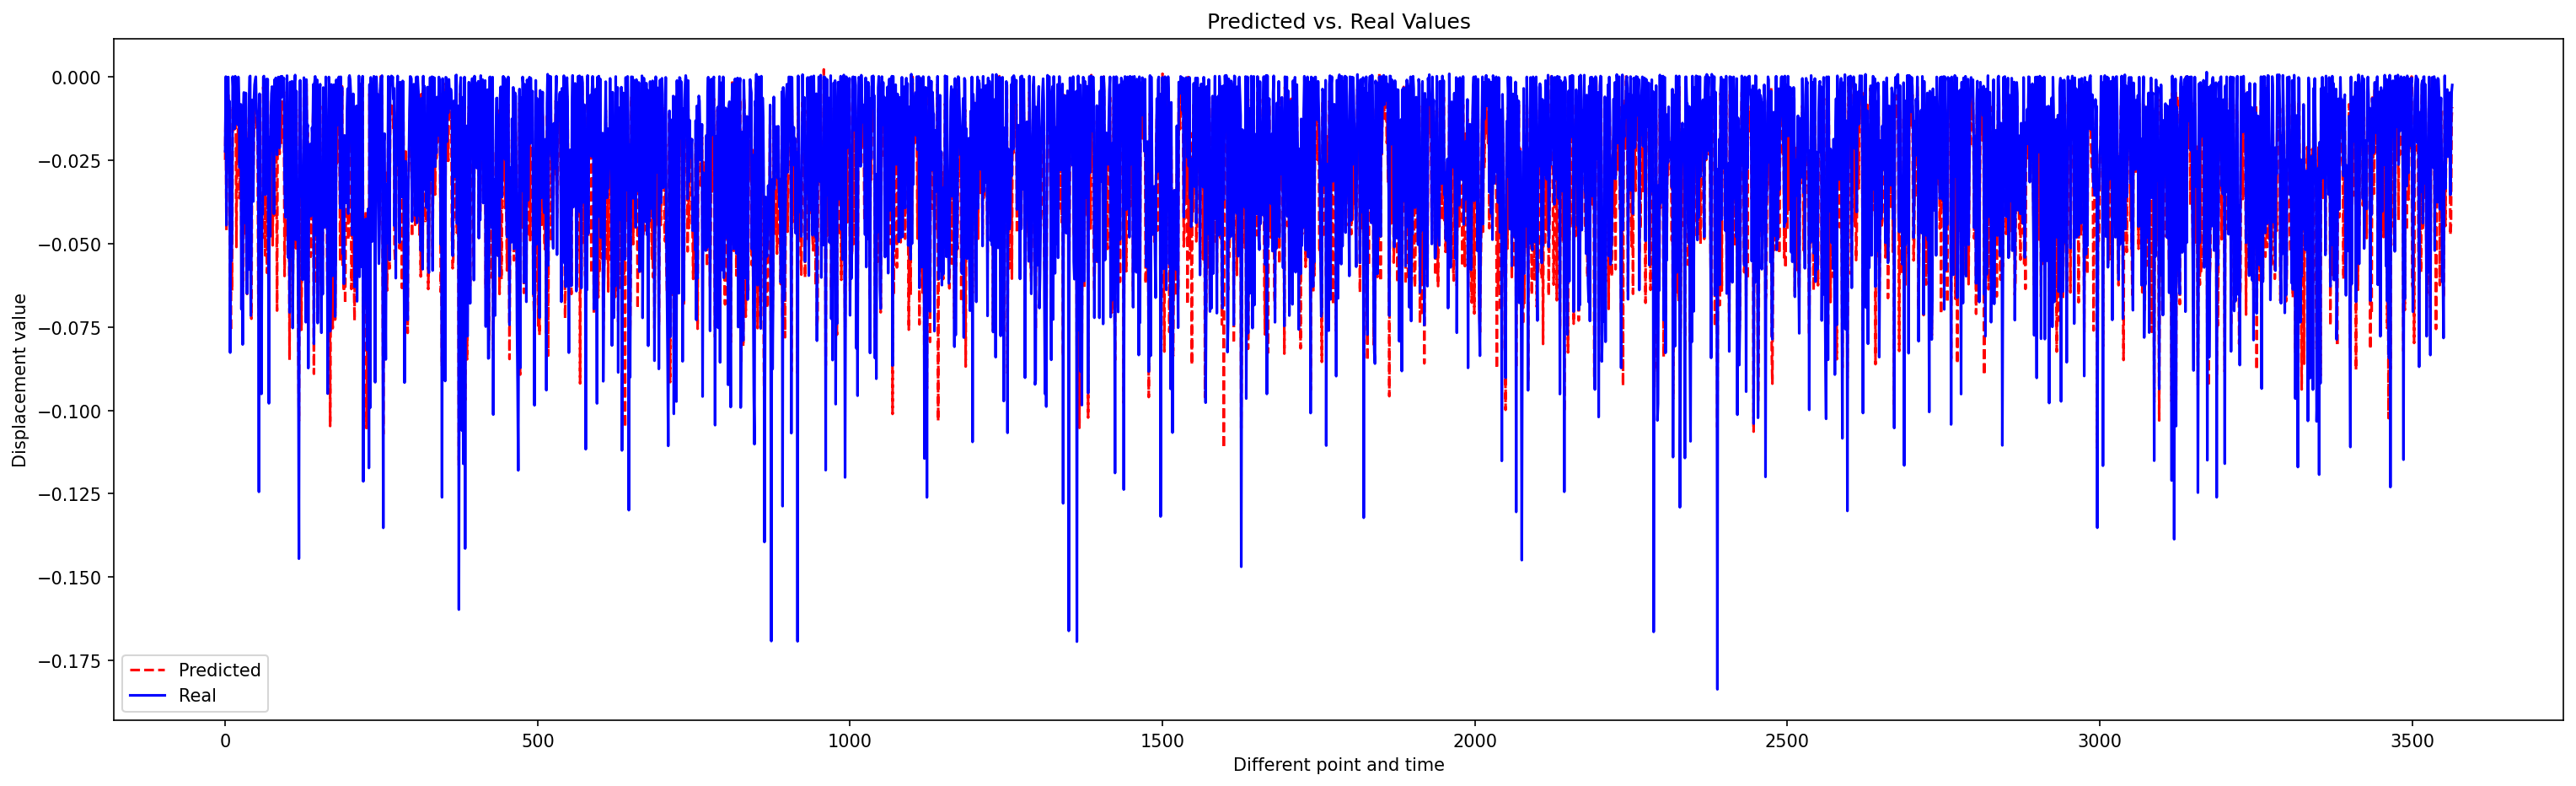

In [ ]:
plt.figure(figsize=(25,7), dpi=150)

# Plot the predicted values with a dashed red line
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')

# Plot the real values with a solid blue line
plt.plot(y_test, label='Real', color='blue', linestyle='-')

# Add legend
plt.legend()

# Add labels and title
plt.xlabel('Different point and time')
plt.ylabel('Displacement value')
plt.title('Predicted vs. Real Values')

# Show the plot
plt.show()


### Make Treshhold

In [ ]:
x_test, y_test= next(data_generator(trainSimple_scaled, sequence_length, batch_size=3565))

In [ ]:
y_pred= model4.predict(x_test)

112/112 [==============================] - 1s 10ms/step


In [ ]:
# Calculate the absolute difference between predicted and real values
diff = abs(y_pred - y_test)

# Calculate the threshold for the error
threshold = 0.2 * abs(y_test)

In [ ]:
threshold

array([[0.01781504],
       [0.00043738],
       [0.00084796],
       ...,
       [0.00342926],
       [0.00364398],
       [0.00681234]])

In [ ]:
diff > threshold

array([[False],
       [ True],
       [ True],
       ...,
       [ True],
       [False],
       [ True]])

In [ ]:
# Create a mask for the rows with error > threshold
mask = diff > threshold

# Filter the data with the mask to create the False dataframe
false_df = pd.DataFrame({'predicted': y_pred[mask], 'real': y_test[mask]})

# Filter the data with the inverted mask to create the True dataframe
true_df = pd.DataFrame({'predicted': y_pred[~mask], 'real': y_test[~mask]})

In [ ]:
true_df.shape[0] / (true_df.shape[0]+ false_df.shape[0])*100

26.704067321178123

In [ ]:
# Plot the True dataframe
plt.figure(figsize=(35,15), dpi=150)
plt.plot(true_df['predicted'], label='Predicted')
plt.plot(true_df['real'], label='Real')
plt.legend()
plt.xlabel('Different point and time')
plt.ylabel('Displacement value')
plt.title('Predicted vs. Real Values (Error < 50%)')
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(true_df["predicted"], true_df["real"]))
# Calculate R2 score
r2 = r2_score(true_df["predicted"], true_df["real"])

# Calculate MSE
mse = mean_squared_error(true_df["predicted"], true_df["real"])

# Print the results
print("RMSE: ", rmse)
print("R2 Score: ", r2)
print("MSE: ", mse)

RMSE:  0.006084943212913063
R2 Score:  0.916169230581825
MSE:  3.7026533904376745e-05


### continuse

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Assuming you have y_pred and y_real as numpy arrays

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate R2 score
r2 = r2_score(y_test, y_pred)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)

# Print the results
print("RMSE: ", rmse)
print("R2 Score: ", r2)
print("MSE: ", mse)


RMSE:  0.01439313641310161
R2 Score:  0.7459419746117888
MSE:  0.00020716237580615144


### Draw per step and Loc

In [ ]:
import seaborn as sns

In [ ]:
pathLocation = "/content/gdrive/MyDrive/Colab Notebooks/FlacAIModels/deepLearning/dataset/location.csv"
location = pd.read_csv(pathLocation)
location

In [ ]:
merged_df = pd.merge(location, trainSimple, left_on='location_id', right_on='locationID').loc[:,["location_id","location"]]
# show the result
merged_df["location"].value_counts()

In [ ]:
merged_df[merged_df["location"]=="(0, 1)"]

In [ ]:
idx = pd.IndexSlice
trainSimple_1275 = trainSimple.loc[idx[2010, :], :]
# get the row indices for the same rows in trainSimple_Scaled
row_indices = trainSimple_1275.index.get_level_values(1)
trainSimple_Scaled_1275 = trainSimple_scaled[row_indices, :]

idx = pd.IndexSlice
testSimple_1275 = testSimple.loc[idx[2010, :], :]
# get the row indices for the same rows in trainSimple_Scaled
row_indices = testSimple_1275.index.get_level_values(1)
testSimple_Scaled_1275 = testSimple_scaled[row_indices, :]


In [ ]:
idx = pd.IndexSlice
trainSimple_1765 = trainSimple.loc[idx[2010, :], :]
# get the row indices for the same rows in trainSimple_Scaled
row_indices = trainSimple_1765.index.get_level_values(1)
trainSimple_Scaled_1765 = trainSimple_scaled[row_indices, :]

idx = pd.IndexSlice
testSimple_1765 = testSimple.loc[idx[2010, :], :]
# get the row indices for the same rows in trainSimple_Scaled
row_indices = testSimple_1765.index.get_level_values(1)
testSimple_Scaled_1765 = testSimple_scaled[row_indices, :]

In [ ]:
testSimple_1275

faceP    groutP  treat  waterT  burdenL  geoProp_0  \
location_id step                                                          
2010        81     50000.0  180000.0      0       3       51          0   
            81     50000.0  280000.0      1       4      122          0   
            81     50000.0  310000.0      0       6      101          0   
            81     50000.0  350000.0      0       4       26          0   
            81     60000.0  100000.0      0       3       53          0   
...                    ...       ...    ...     ...      ...        ...   
            100   310000.0  210000.0      0       6      118          0   
            100   310000.0  280000.0      0       5      121          0   
            100   310000.0  290000.0      0       5       29          0   
            100   310000.0  330000.0      0       4      102          0   
            100   310000.0  350000.0      1       3       12          0   

                  geoProp_2  geoProp_3  geoProp_4  geoProp_5  geoProp_6  \
location_id step                                                          
2010        81            1          0          0          0          0   
            81            0          0          0          0          1   
            81            0          0          0          0          1   
            81            0          0          0          0          0   
            81            0          0          0          0          1   
...                     ...        ...        ...        ...        ...   
            100           0          1          0          0          0   
            100           0          1          0          0          0   
            100           0          0          0          1          0   
            100           0          0          0          0          0   
            100           0          0          0          0          0   

                  geoProp_7  locationID  soilExcavation  shifted_zDisp(m)_1  \
location_id step                                                              
2010        81            0        2010               0            0.000000   
            81            0        2010               0            0.000000   
            81            0        2010               1            0.000000   
            81            1        2010               0            0.000000   
            81            0        2010               1            0.000000   
...                     ...         ...             ...                 ...   
            100           0        2010               1           -0.118452   
            100           0        2010               1           -0.107372   
            100           0        2010               1           -0.066745   
            100           1        2010               0           -0.095680   
            100           0        2010               0           -0.065974   

                  zDisp(m)  
location_id step            
2010        81   -0.078582  
            81   -0.112657  
            81   -0.048166  
            81   -0.027732  
            81   -0.039606  
...                    ...  
            100  -0.119933  
            100  -0.108594  
            100  -0.067734  
            100  -0.097481  
            100  -0.067394  

[4800 rows x 16 columns]

In [ ]:
x_test, y_test= next(data_generator(trainSimple_scaled, sequence_length, batch_size=len(trainSimple_Scaled_1275)))
y_pred= model4.predict(x_test)
predTrain = pd.DataFrame({'predicted': y_pred[:,0], 'real': y_test[:,0]},index=trainSimple_1275.index)
# calculate R2 score
r2 = r2_score(predTrain['real'], predTrain['predicted'])

# calculate RMSE
rmse = mean_squared_error(predTrain['real'], predTrain['predicted'], squared=False)

# calculate MSE
mse = mean_squared_error(predTrain['real'], predTrain['predicted'])

print('R2:', r2)
print('RMSE:', rmse)
print('MSE:', mse)

603/603 [==============================] - 6s 10ms/step
R2: 0.7397390755547949
RMSE: 0.014093156015244395
MSE: 0.0001986170464700193


In [ ]:
x_test, y_test= next(data_generator(testSimple_scaled, sequence_length, batch_size=len(testSimple_Scaled_1275)))
y_pred= model4.predict(x_test)
predTest = pd.DataFrame({'predicted': y_pred[:,0], 'real': y_test[:,0]},index=testSimple_1275.index)
# calculate R2 score
r2 = r2_score(predTest['real'], predTest['predicted'])

# calculate RMSE
rmse = mean_squared_error(predTest['real'], predTest['predicted'], squared=False)

# calculate MSE
mse = mean_squared_error(predTest['real'], predTest['predicted'])

print('R2:', r2)
print('RMSE:', rmse)
print('MSE:', mse)

150/150 [==============================] - 1s 9ms/step
R2: 0.34399839886366324
RMSE: 0.03067755014662292
MSE: 0.000941112082998564


In [ ]:
data = pd.concat([predTrain ,predTest])
data1275 = data.reset_index(level='location_id').drop(columns="location_id")
data1275.loc[80:,:]

In [ ]:
(data1275.loc[81:,:].groupby('step')['predicted'].mean() + trendTest)/2

In [ ]:
# Group the data by location_id and take the mean of each group to get the trend
trendTrain = trainSimple_1275.groupby('step')['zDisp(m)'].mean()
trendTest = testSimple_1275.groupby('step')['zDisp(m)'].mean()
trend1 = (data1275.loc[81:,:].groupby('step')['predicted'].mean() + trendTest)/2
# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# Plot trend1 in red
ax.plot(trendTrain.index, trendTrain.values, color='red', label='Real')

# Plot trend2 in Red
ax.plot(trendTest.index, trendTest.values, color='red', linestyle='--')

# Plot Prediction in Blue
ax.plot(trend1.index, trend1.values, color='blue', label='Prediction', linestyle='-')

# Set title and axis labels
ax.set_title('Time Series Trends', fontsize=16)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Mean Value Disp (m)', fontsize=12)

# Set y-axis limits
ax.set_ylim([-0.12, 0])

# Add legend
ax.legend(fontsize=12)

# Show the plot
plt.show()

### make classification

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

In [ ]:
def classify_error(y_pred, y_real):
    # Calculate the absolute error
    error = np.abs(y_pred - y_real)

    # Calculate the error percentage
    error_percentage = (error / np.abs(y_real)) * 100

    # Create a mask for error less than or equal to 10%
    mask = error_percentage <= 180

    # Create a classification array with 1s and 0s
    classification = np.where(mask, 1, 0)

    return classification,error_percentage

In [ ]:
classification,error_percentage = classify_error(y_pred, y_test)
print(sum(classification),len(classification))

[1000] 1000


In [ ]:

def classify_error(y_pred, y_real):
    # Calculate the absolute error
    error = np.abs(y_pred - y_real)

    # Calculate the error percentage
    error_percentage = (error / np.abs(y_real)) * 100

    # Create bins for the error percentage
    bins = np.array([0, 10, np.inf])

    # Create labels for the bins
    labels = np.array([0, 1])

    # Convert error percentage into discrete categories using binning
    categories = np.digitize(error_percentage, bins, right=True)

    # Create a classification array with 1s and 0s
    classification = np.where(categories == 1, 1, 0)

    # Convert real values into discrete categories using binning
    real_categories = np.digitize(y_real, bins, right=True)

    # Create a confusion matrix
    confusion_mat = confusion_matrix(real_categories, classification, labels=labels)

    return confusion_mat


In [ ]:
confusion_mat = classify_error(y_pred, y_test)
print(confusion_mat)

[[2835  497]
 [ 233    0]]


In [ ]:
from sklearn.metrics import f1_score, precision_score, accuracy_score

In [ ]:
def calculate_f1_score(confusion_mat):
    true_positive = confusion_mat[1, 1]
    false_positive = confusion_mat[0, 1]
    false_negative = confusion_mat[1, 0]

    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)

    f1_score = 2 * (precision * recall) / (precision + recall)

    return f1_score

def calculate_precision(confusion_mat):
    true_positive = confusion_mat[1, 1]
    false_positive = confusion_mat[0, 1]

    precision = true_positive / (true_positive + false_positive)

    return precision

def calculate_accuracy(confusion_mat):
    true_positive = confusion_mat[1, 1]
    false_positive = confusion_mat[0, 1]
    false_negative = confusion_mat[1, 0]
    true_negative = confusion_mat[0, 0]

    accuracy = (true_positive + true_negative) / (true_positive + false_positive + false_negative + true_negative)

    return accuracy


f1_score = calculate_f1_score(confusion_mat)
precision = calculate_precision(confusion_mat)
accuracy = calculate_accuracy(confusion_mat)

print("F1 score:", f1_score)
print("Precision:", precision)
print("Accuracy:", accuracy)


F1 score: nan
Precision: 0.0
Accuracy: 0.7952314165497896


<ipython-input-355-188e8fa249e6>:9: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = 2 * (precision * recall) / (precision + recall)


In [ ]:
import numpy as np

In [ ]:
TPR = confusion_mat[1, 1] / (confusion_mat[1, 1] + confusion_mat[1, 0])
FPR = confusion_mat[0, 1] / (confusion_mat[0, 0] + confusion_mat[0, 1])

<ipython-input-53-817b6c527d06>:1: RuntimeWarning: invalid value encountered in long_scalars
  TPR = confusion_mat[1, 1] / (confusion_mat[1, 1] + confusion_mat[1, 0])


In [ ]:
TPR = 1 / (1 + 0)
FPR =614 / (9385 + 614)
TPR, FPR

(1.0, 0.061406140614061404)

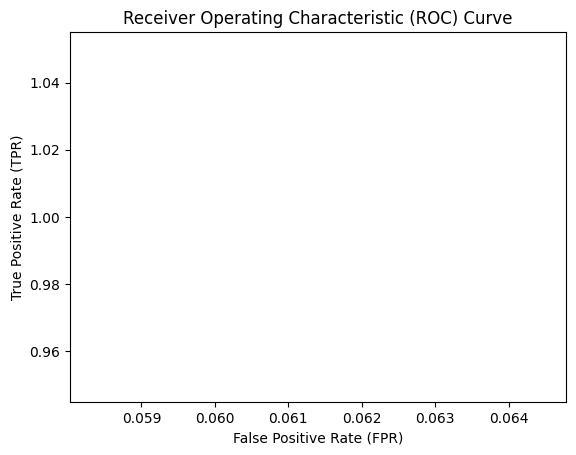

In [ ]:
import matplotlib.pyplot as plt

# Plot ROC curve
plt.plot(FPR, TPR)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()


## Four layer (128,64,32,16)_without Loc

In [ ]:
train_features = trainSimple.iloc[:, :-2].drop(columns=["locationID"]).values
train_target = trainSimple.iloc[:, [-2,-1]].values

# Scale the features only
scaler = MinMaxScaler()
train_features_scaled = scaler.fit_transform(train_features)

# Combine the scaled features and the target
trainSimple_scaled = np.hstack((train_features_scaled, train_target))

In [ ]:
test_features = testSimple.iloc[:, :-2].drop(columns=["locationID"]).values
test_target = testSimple.iloc[:,[-2,-1]].values
# Scale the features only
scaler = MinMaxScaler()
test_features_scaled = scaler.fit_transform(test_features)

# Combine the scaled features and the target
testSimple_scaled = np.hstack((test_features_scaled, test_target))

In [ ]:
trainSimple_scaled.shape

(790726, 15)

### Prepare for NN

In [ ]:
# Define the number of features in the input data
sequence_length = 80
num_features = trainSimple_scaled.shape[1] - 1
num_features

14

In [ ]:
# Define a generator function to load the data in batches
def data_generator(data, sequence_length, batch_size):
    num_sequences = len(data) - sequence_length
    while True:
        batch_X = np.zeros((batch_size, sequence_length, num_features))
        batch_y = np.zeros((batch_size, 1))
        for i in range(batch_size):
            idx = random.randint(0, num_sequences-1)
            batch_X[i] = data[idx:idx+sequence_length, :-1]
            batch_y[i] = data[idx+sequence_length, -1]
        yield batch_X, batch_y

# Define the batch size
batch_size = 128

# Define the number of training and validation steps per epoch
train_steps_per_epoch = (len(trainSimple) - sequence_length) // batch_size
val_steps_per_epoch = (len(testSimple) - sequence_length) // batch_size

In [ ]:
sequence_length, num_features

(80, 14)

### Architecture and Solve

In [ ]:
# Define the input shape
input_shape = (sequence_length, num_features)

# Define the number of LSTM units in the layers
lstm_units_1 = 128
lstm_units_2 = 64
lstm_units_3 = 64
lstm_units_4 = 32

# Define the input layer
inputs = Input(shape=input_shape)

x1 = LSTM(lstm_units_1, return_sequences=True, activation="tanh", recurrent_activation="sigmoid")(inputs)
x2 = LSTM(lstm_units_2, return_sequences=True, activation="tanh", recurrent_activation="sigmoid")(x1)
x3 = LSTM(lstm_units_3, return_sequences=True, activation="tanh", recurrent_activation="sigmoid")(x2)
x4 = LSTM(lstm_units_4, kernel_regularizer=l2(0.001), activation="tanh", recurrent_activation="sigmoid")(x3)  # Added layer

# Add a dense output layer with L2 regularization
outputs = Dense(1, activation="linear")(x4)

# Define the model
model4S = Model(inputs=inputs, outputs=outputs)

# Compile the model
model4S.compile(loss='mse', optimizer='sgd')
model4S.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 80, 14)]          0         
                                                                 
 lstm (LSTM)                 (None, 80, 128)           73216     
                                                                 
 lstm_1 (LSTM)               (None, 80, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 80, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 168,097
Trainable params: 168,097
Non-trainab

In [ ]:
from tensorflow.python.distribute.input_lib import time
# Train the model
start_time = time.time()
historyNew5 = model4S.fit(data_generator(trainSimple_scaled, sequence_length, batch_size),
          steps_per_epoch=train_steps_per_epoch,
          epochs=60,
          validation_data=data_generator(testSimple_scaled, sequence_length, batch_size),
          validation_steps=val_steps_per_epoch,
          callbacks=[EarlyStopping(patience=6, restore_best_weights=True)])
end_time = time.time()



Epoch 1/60
6176/6176 [==============================] - 129s 20ms/step - loss: 0.0771 - val_loss: 0.0707
Epoch 2/60
6176/6176 [==============================] - 122s 20ms/step - loss: 0.0603 - val_loss: 0.0556
Epoch 3/60
6176/6176 [==============================] - 122s 20ms/step - loss: 0.0472 - val_loss: 0.0439
Epoch 4/60
6176/6176 [==============================] - 121s 20ms/step - loss: 0.0370 - val_loss: 0.0345
Epoch 5/60
6176/6176 [==============================] - 120s 19ms/step - loss: 0.0289 - val_loss: 0.0271
Epoch 6/60
6176/6176 [==============================] - 122s 20ms/step - loss: 0.0226 - val_loss: 0.0210
Epoch 7/60
6176/6176 [==============================] - 129s 21ms/step - loss: 0.0176 - val_loss: 0.0164
Epoch 8/60
6176/6176 [==============================] - 120s 20ms/step - loss: 0.0138 - val_loss: 0.0130
Epoch 9/60
6176/6176 [==============================] - 120s 19ms/step - loss: 0.0108 - val_loss: 0.0103
Epoch 10/60
6176/6176 [==============================] 

In [ ]:
count_time= end_time - start_time
print(f"sloving, Time taken: {count_time:.2f} seconds")

sloving, Time taken: 6057.77 seconds


In [ ]:
# Save the model to a file
pathSave = '/content/gdrive/MyDrive/Colab Notebooks/FlacAIModels/deepLearning/surfaceDispSevilleUni/'
model4S.save(pathSave+ 'model4LSTM_NotLoc.h5')

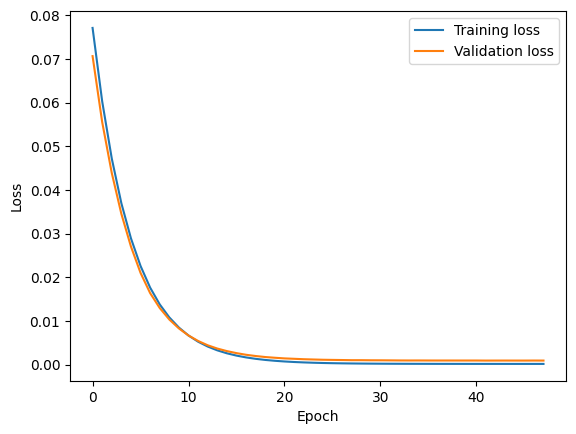

In [ ]:
plt.plot(historyNew5.history['loss'], label='Training loss')
plt.plot(historyNew5.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Test model

In [ ]:
import keras

# Save the model to a file
model4S = keras.models.load_model(pathSave+ 'model4LSTM_NotLoc.h5')

In [ ]:
import math
from tqdm import tqdm

# Define the batch size
batch_size = 5000

# Calculate the number of batches for the entire dataset
num_batches = math.ceil((len(trainSimple_scaled) - sequence_length) / batch_size)
num_batches

159

In [ ]:
# Initialize an empty array to store the predictions
all_preds = np.array([])
all_reals = np.array([])

# Loop over all batches and make predictions
for i in tqdm(range(num_batches)):
    # Generate a batch of data
    batch_X, batch_y = next(data_generator(trainSimple_scaled, sequence_length, batch_size=batch_size))

    # Make predictions on the batch
    batch_preds = model4S.predict(batch_X,verbose=False)

    # Append the predictions to the array
    all_preds = np.concatenate([all_preds, batch_preds.reshape(-1)])
    all_reals = np.concatenate([all_reals, batch_y.reshape(-1)])

# Print the shape of the predictions array
print("Shape of predictions:", all_preds.shape)

100%|██████████| 159/159 [03:32<00:00,  1.33s/it]

Shape of predictions: (795000,)


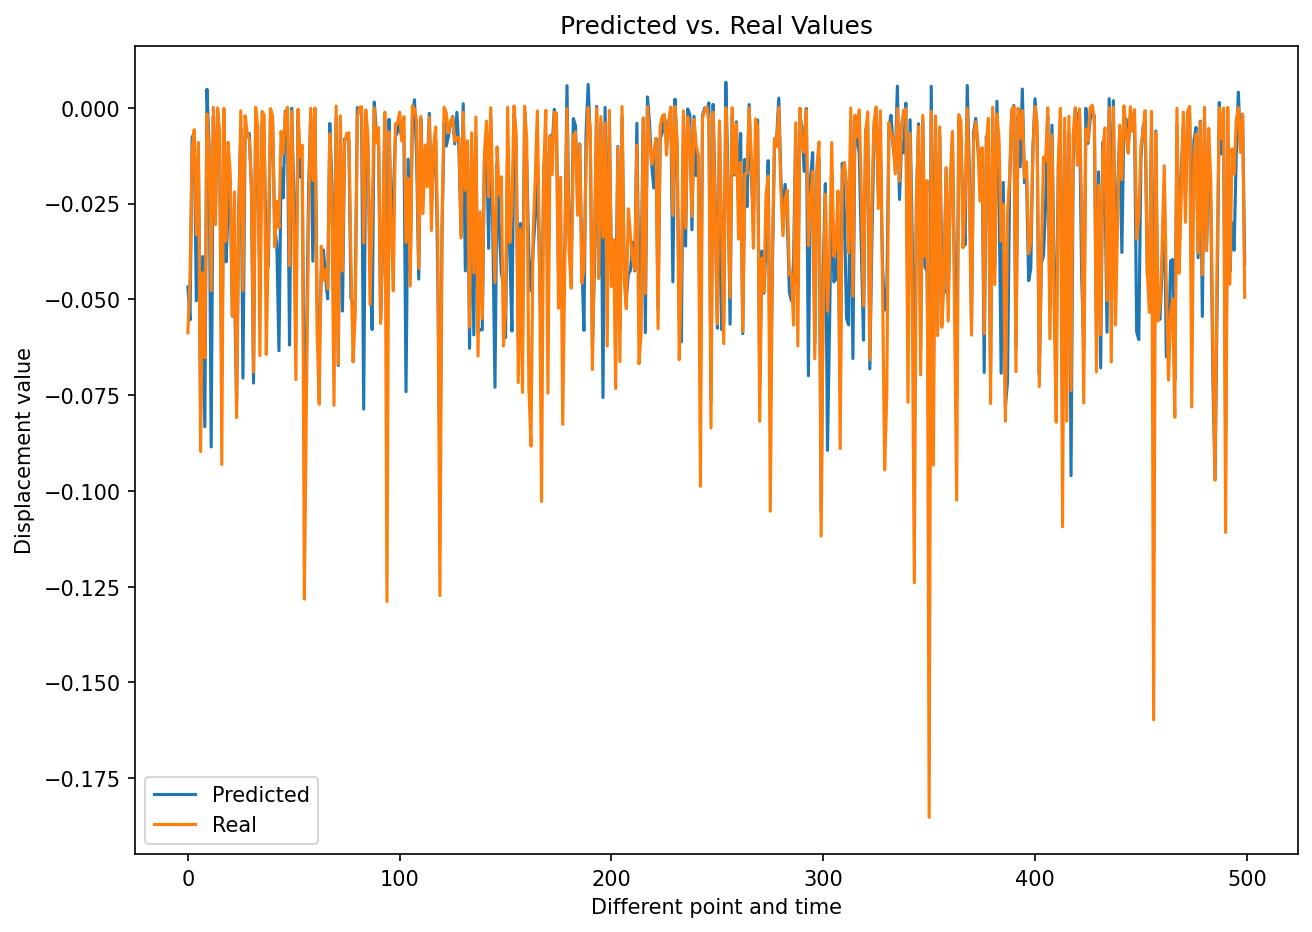

In [ ]:
plt.figure(figsize=(10,7), dpi=150)
# Plot the predicted values
plt.plot(y_pred, label='Predicted')

# Plot the real values
plt.plot(y_test, label='Real')

# Add legend
plt.legend()

# Add labels and title
plt.xlabel('Different point and time')
plt.ylabel('Displacement value')
plt.title('Predicted vs. Real Values')

# Show the plot
plt.show()


### continuse

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Assuming you have y_pred and y_real as numpy arrays

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(all_reals, all_preds))

# Calculate R2 score
r2 = r2_score(all_reals, all_preds)

# Calculate MSE
mse = mean_squared_error(all_reals, all_preds)

# Print the results
print("RMSE: ", rmse)
print("R2 Score: ", r2)
print("MSE: ", mse)


RMSE:  0.013320621310234542
R2 Score:  0.774774199614323
MSE:  0.00017743895209067461


### make classification

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

In [ ]:
def replace_values(x):
    if x > -9e-7:
        return 0
    elif -9e-7 >= x > -0.02:
        return 1
    else:
        return 2

In [ ]:
# apply the function to each element of the array
biPred = np.vectorize(replace_values)(all_preds)
biReal = np.vectorize(replace_values)(all_reals)

In [ ]:
# get the unique values and their counts
unique_values, value_counts = np.unique(biPred, return_counts=True)

# print the results
for value, count in zip(unique_values, value_counts):
    print(f"{value}: {count}")

0: 50420
1: 344895
2: 399685


In [ ]:
# get the unique values and their counts
unique_values, value_counts = np.unique(biReal, return_counts=True)

# print the results
for value, count in zip(unique_values, value_counts):
    print(f"{value}: {count}")

0: 51802
1: 360124
2: 383074


In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

In [ ]:
# Create confusion matrix
conf_matrix = confusion_matrix(biReal, biPred)

# Print the confusion matrix
print("Confusion matrix:")
print(conf_matrix)

Confusion matrix:
[[ 16934  34536    332]
 [ 33486 287600  39038]
 [     0  22759 360315]]


In [ ]:
from tabulate import tabulate

# Calculate the confusion matrix as percentages
conf_matrix_percent = conf_matrix / np.sum(conf_matrix) * 100

# Define the headers and row labels for the table
headers = ['', 'Actual 0', 'Actual 1', 'Actual 2']
row_labels = ['Predicted 0', 'Predicted 1', 'Predicted 2']

# Print the confusion matrix as a table
print("Confusion matrix (percentages):")
print(tabulate(conf_matrix_percent, headers=headers, showindex=row_labels, floatfmt='.2f', tablefmt='fancy_grid'))

Confusion matrix (percentages):
╒═════════════╤════════════╤════════════╤════════════╕
│             │   Actual 0 │   Actual 1 │   Actual 2 │
╞═════════════╪════════════╪════════════╪════════════╡
│ Predicted 0 │       2.13 │       4.34 │       0.04 │
├─────────────┼────────────┼────────────┼────────────┤
│ Predicted 1 │       4.21 │      36.18 │       4.91 │
├─────────────┼────────────┼────────────┼────────────┤
│ Predicted 2 │       0.00 │       2.86 │      45.32 │
╘═════════════╧════════════╧════════════╧════════════╛


In [ ]:
# Convert labels to binary format
biReal_ = label_binarize(biReal, classes=[0, 1, 2])
biPred_ = label_binarize(biPred, classes=[0, 1, 2])

# Compute AUC score
auc_score = roc_auc_score(biReal_, biPred_, multi_class='ovr')

# Print the AUC score
print('AUC Score: {:.2f}'.format(auc_score))

AUC Score: 0.80


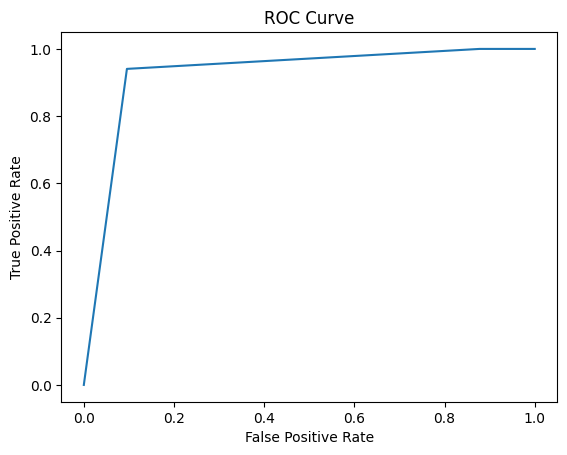

In [ ]:
# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(biReal, biPred, pos_label=2)

# Plot ROC curve
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Print the classification report
print(classification_report(biReal, biPred))


              precision    recall  f1-score   support

           0       0.34      0.33      0.33     51802
           1       0.83      0.80      0.82    360124
           2       0.90      0.94      0.92    383074

    accuracy                           0.84    795000
   macro avg       0.69      0.69      0.69    795000
weighted avg       0.83      0.84      0.83    795000



# Paper visulaition

## Test and train

In [ ]:
x_test, y_test= next(data_generator(testSimple_scaled, sequence_length, batch_size=3565))

In [ ]:
y_predRNN = model0.predict(x_test)
y_predGRU = model1.predict(x_test)
y_predLSTM = model4.predict(x_test)

112/112 [==============================] - 1s 7ms/step


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Assuming you have y_pred and y_real as numpy arrays

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_predRNN))

# Calculate R2 score
r2 = r2_score(y_test, y_predRNN)

# Calculate MSE
mse = mean_squared_error(y_test, y_predRNN)

# Print the results
print("RMSE: ", rmse)
print("R2 Score: ", r2)
print("MSE: ", mse)

RMSE:  0.017183615338701434
R2 Score:  0.7916469202351972
MSE:  0.00029527663610845516


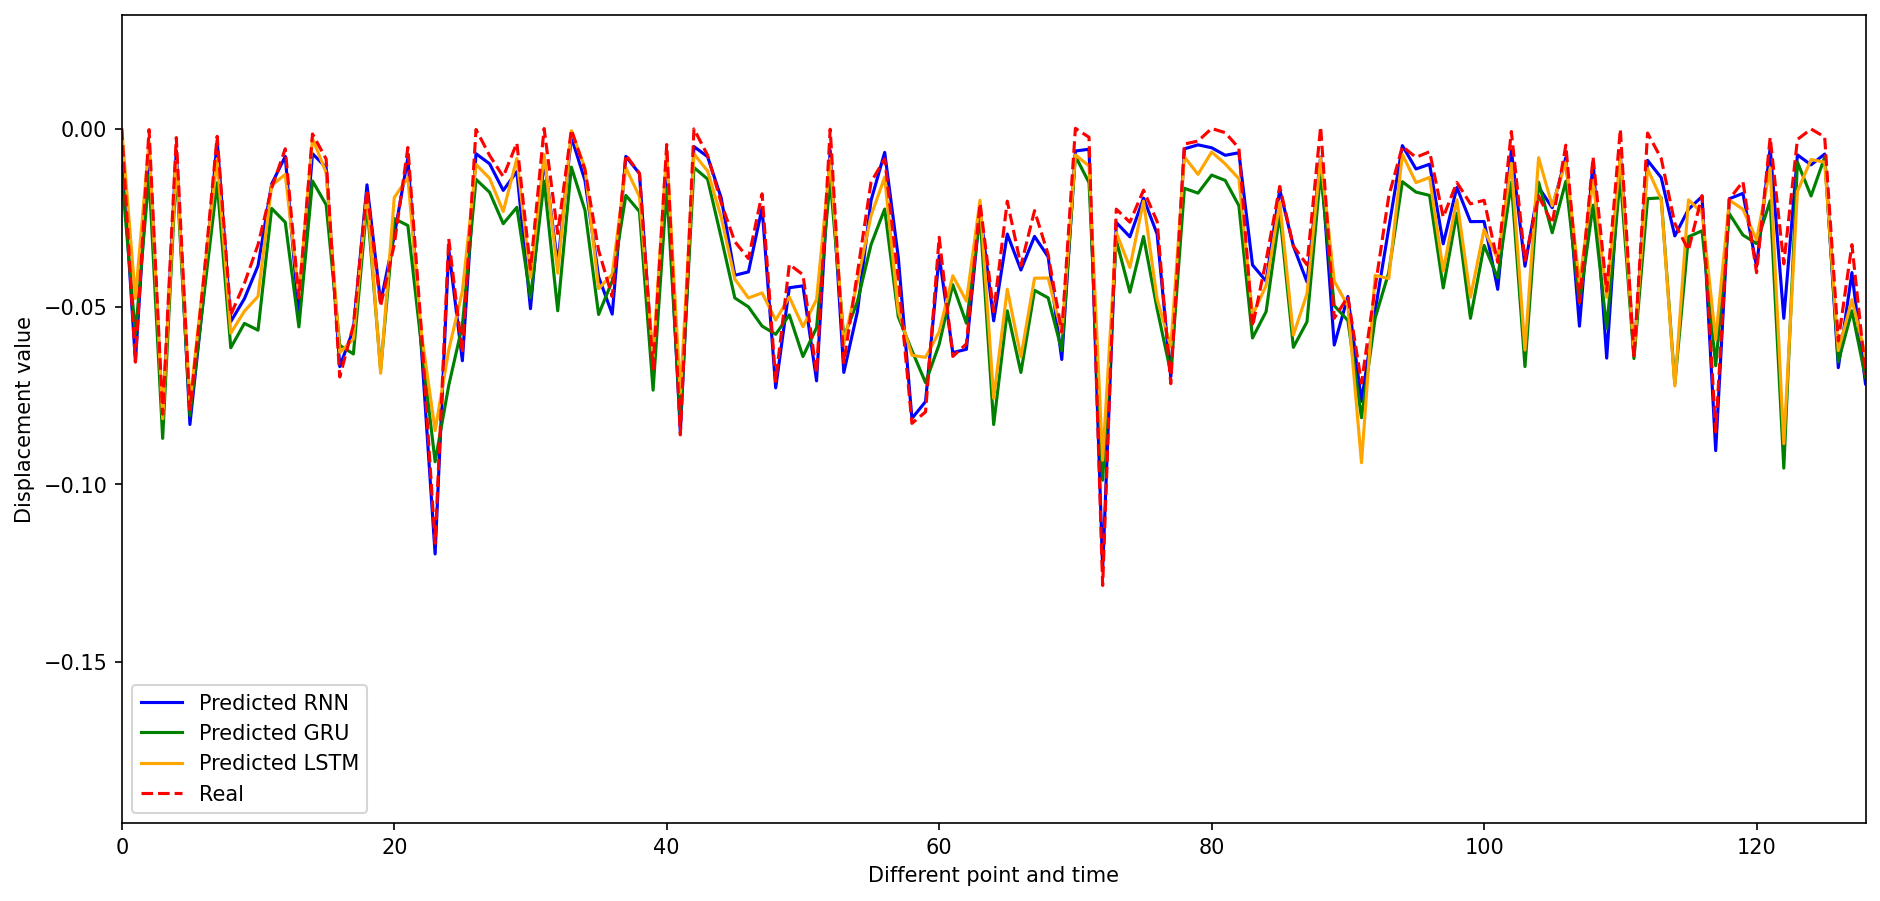

In [ ]:

plt.figure(figsize=(15, 7), dpi=150)

# Plot the predicted values with solid lines
plt.plot(y_predRNN, label='Predicted RNN', linestyle='-', color='blue')
plt.plot(y_predGRU, label='Predicted GRU', linestyle='-', color='green')
plt.plot(y_predLSTM, label='Predicted LSTM', linestyle='-', color='orange')

# Plot the real values with dashed lines
plt.plot(y_test, label='Real', linestyle='--', color='red')

# Add legend
plt.legend()

# Set x-axis limits
plt.xlim(0, batch_size)

# Add labels and title
plt.xlabel('Different point and time')
plt.ylabel('Displacement value')
# plt.title('Predicted vs. Real Values')

# Add gridlines for better readability
plt.grid(False)
# Save the plot with the specified title
plt.savefig('Predicted_vs_Real_Values.png')

# Show the plot
plt.show()

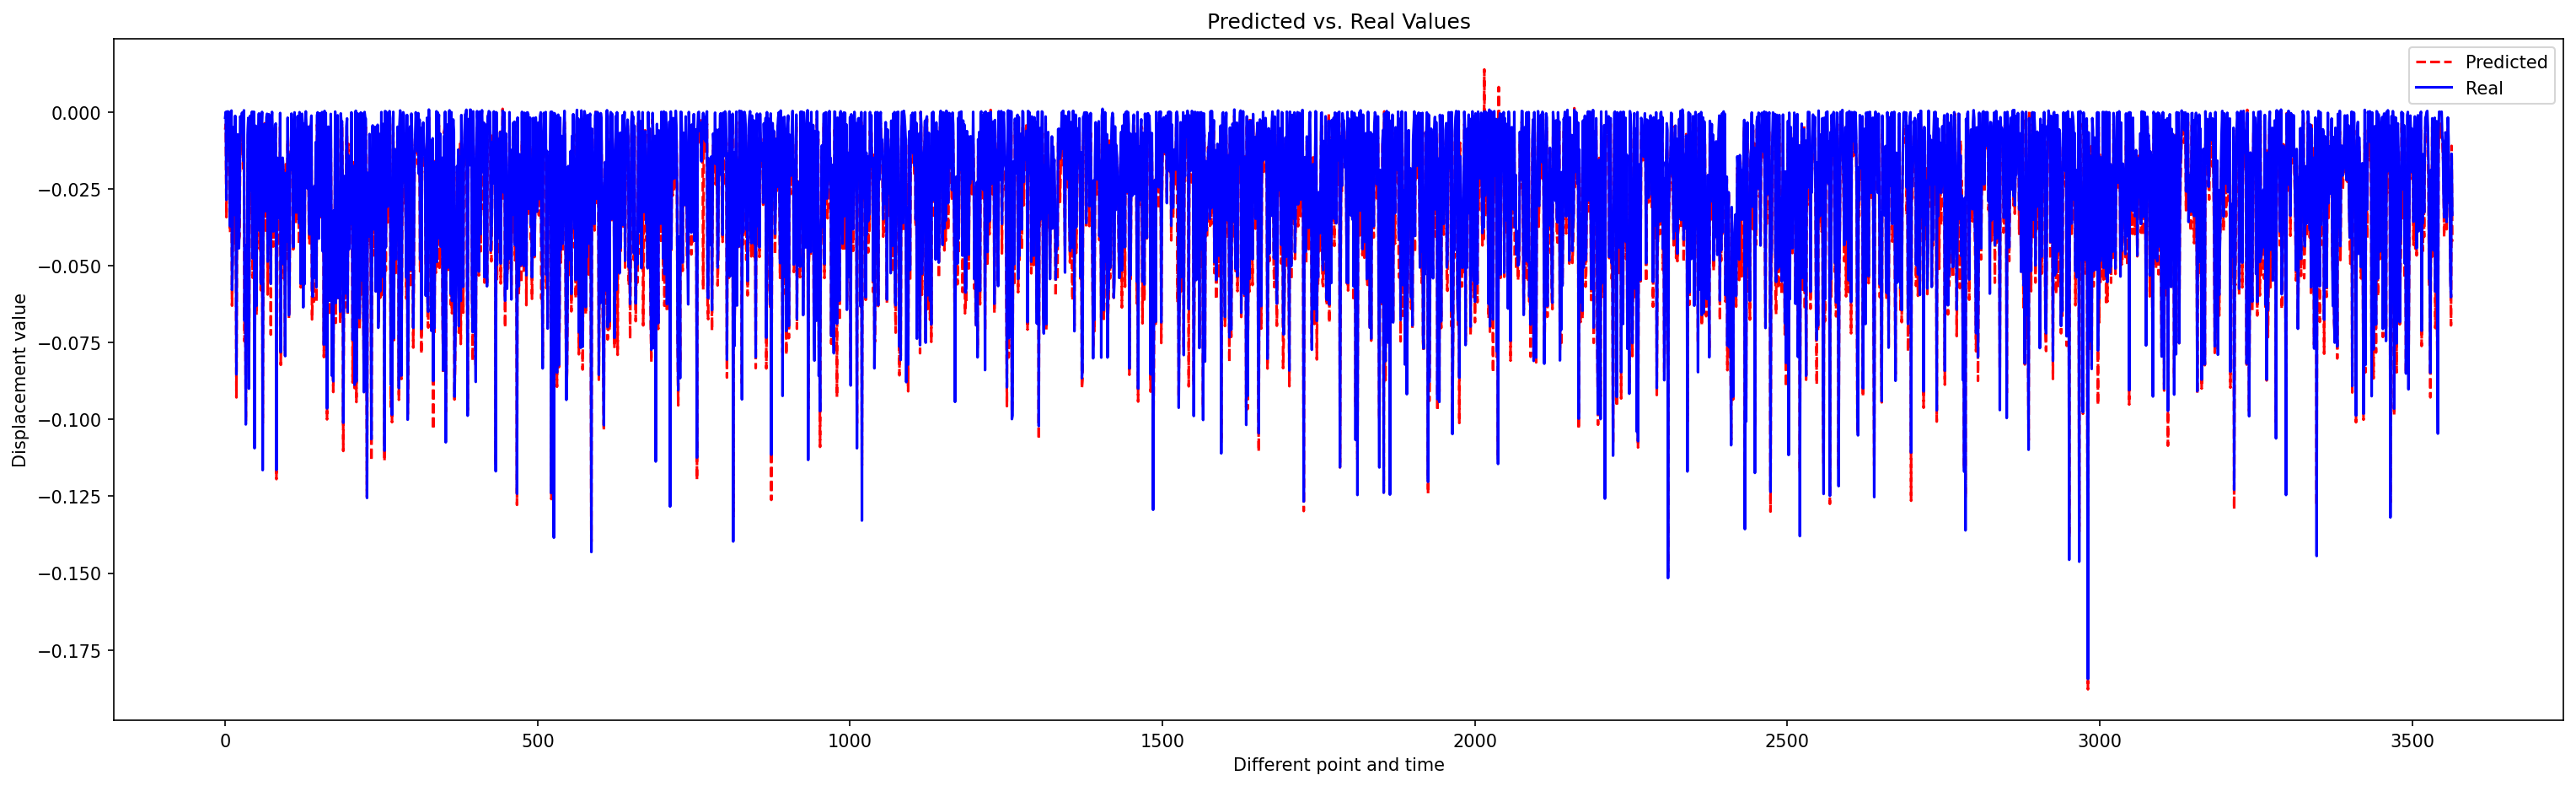

In [ ]:
plt.figure(figsize=(25,7), dpi=150)

# Plot the predicted values with a dashed red line
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')

# Plot the real values with a solid blue line
plt.plot(y_test, label='Real', color='blue', linestyle='-')

# Add legend
plt.legend()

# Add labels and title
plt.xlabel('Different point and time')
plt.ylabel('Displacement value')
plt.title('Predicted vs. Real Values')

# Show the plot
plt.show()


## Test and train Duzgun

In [ ]:
x_test, y_test= next(data_generator(trainSimple_scaled, sequence_length, batch_size=3565))

In [ ]:
y_predRNN = model0.predict(x_test)
# y_predGRU = model1.predict(x_test)
# y_predLSTM = model4.predict(x_test)

112/112 [==============================] - 8s 28ms/step


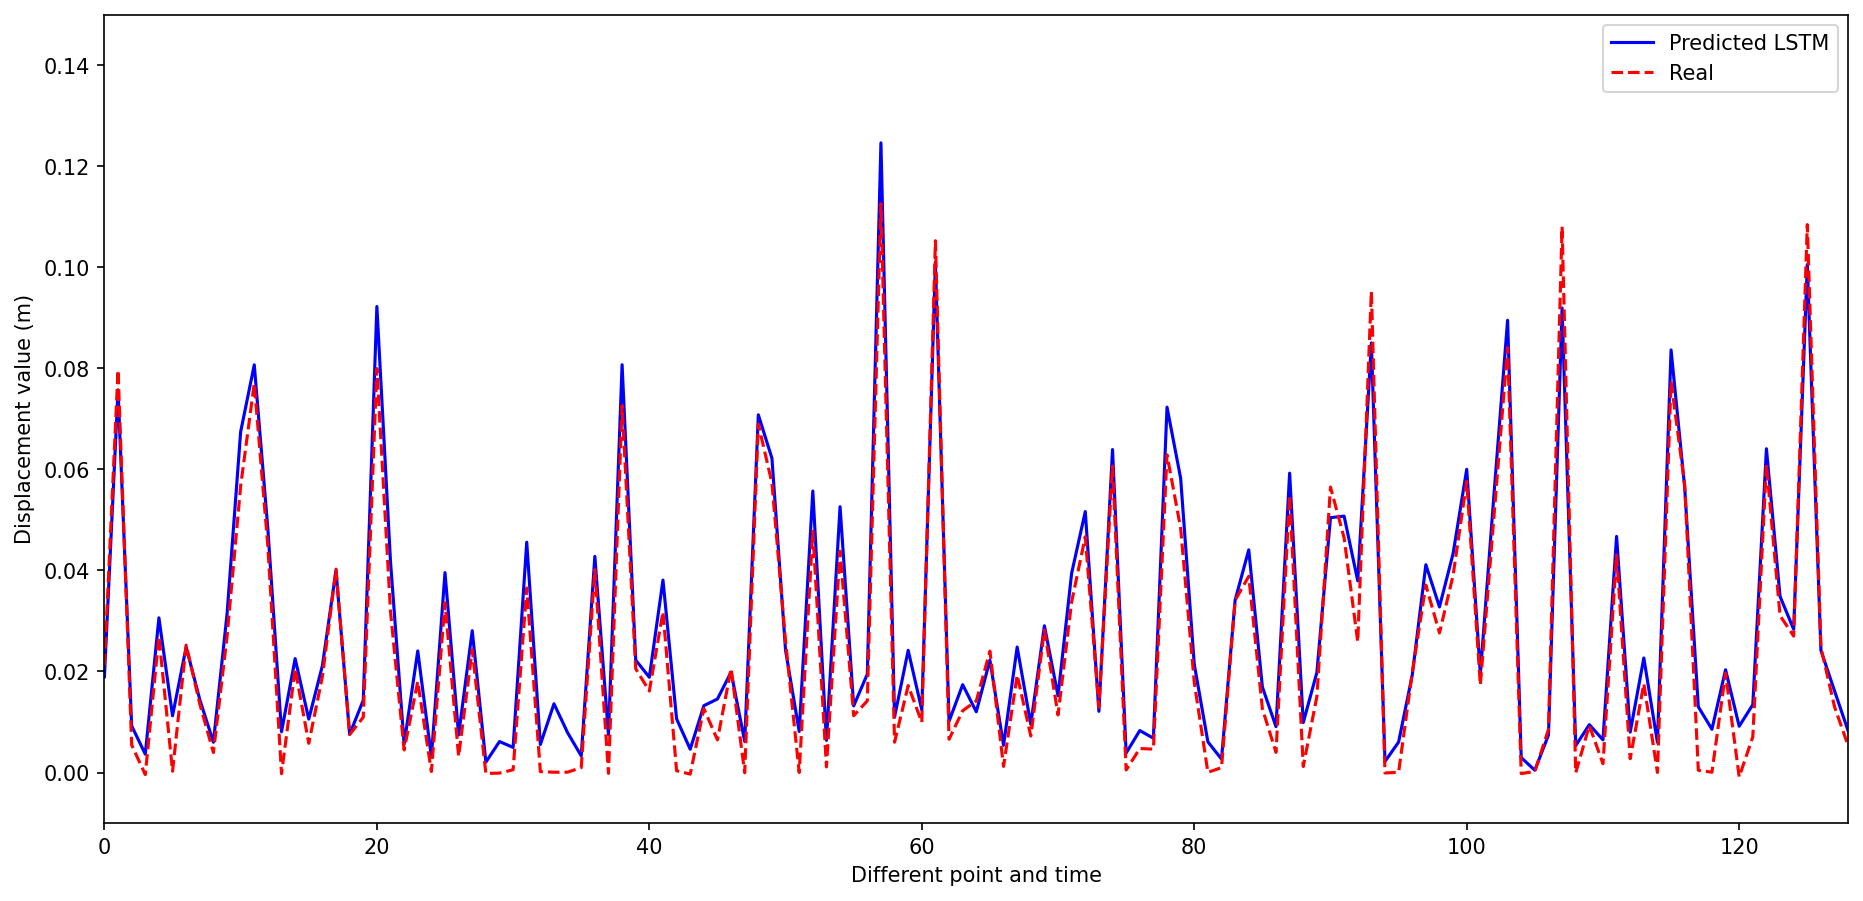

In [ ]:

plt.figure(figsize=(15, 7), dpi=150)

# Plot the predicted values with solid lines
plt.plot(-1* y_predRNN , label='Predicted LSTM', linestyle='-', color='blue')
# plt.plot(y_predGRU, label='Predicted GRU', linestyle='-', color='green')
# plt.plot(y_predLSTM, label='Predicted LSTM', linestyle='-', color='orange')

# Plot the real values with dashed lines
plt.plot(-1*y_test, label='Real', linestyle='--', color='red')

# Add legend
plt.legend()

# Set y-axis limits
plt.ylim(-0.01, 0.15)

# Set x-axis limits
plt.xlim(0, batch_size)

# Add labels and title
plt.xlabel('Different point and time')
plt.ylabel('Displacement value (m)')
# plt.title('Predicted vs. Real Values')

# Add gridlines for better readability
plt.grid(False)
# Save the plot with the specified title
plt.savefig('Predicted_vs_Real_Values.png')

# Show the plot
plt.show()